In [1]:
import re
import json

import requests
import pandas as pd

from datetime import datetime
from joblib import Parallel, delayed
import time

from bs4 import BeautifulSoup

In [2]:
HOME_URL = "https://www.mcgeeandco.com"
TAG_REGIX = re.compile(r"(<!--.*?-->|<[^>]*>)")

In [3]:
def every_page_of_product (each_link):
    if each_link[1] != "c":
        product_url = "{0}{1}".format(HOME_URL, each_link)
        product_html_text = requests.get(product_url).text
        product_soup = BeautifulSoup(product_html_text, "lxml")
   
        purchase_opportunity = product_soup.find("div", class_="buy-wrapper")
        if purchase_opportunity is None:
            answer = "No"
        else:
            add_to_cart = purchase_opportunity.find(class_="btn btn-shop inactive")
            if add_to_cart is None:
                answer = "Yes"
            else:
                button_active = add_to_cart.find("span").text
                if button_active == "Add to Cart":
                    answer = "Possible to order"
                else:
                    answer = "No"
                        
        page_info = json.loads(product_soup.find("script", class_="js-product-json").text)
        product_info = page_info["product"]
        name = product_info["title"]
        description = TAG_REGIX.sub("", product_soup.find("div", class_="description pb-xxs-2 f3").text.strip())
        price = product_info["price"]/100
        created_at = datetime.fromisoformat(product_info["created_at"])
        subcategory_name = subcategory.strip()
        
        results.append({
        "name": name,
        "category": category,
        "subcategory": subcategory_name,
        "price": price,
        "created_at": created_at,
        "purchase_opportunity": answer,
        "description": description                 
        })

    return results

In [4]:
def every_page_in_subcategory (subcategories_url, page_index):
    cur_url = "{0}{1}".format(subcategories_url, page_index + 1)
    print(cur_url)
    subcategories_html_text = requests.get(cur_url).text
    subcategories_soup = BeautifulSoup(subcategories_html_text, "lxml")    
          
    catalog = subcategories_soup.find("div", class_="container py-xxs-2 pt-sm-4 pb-sm-8")
    product_links = [each_link["href"] for each_link in catalog.find_all("a", href=True)] 
    
    Parallel(n_jobs=-1, backend="threading")(delayed(every_page_of_product)(each_link) for each_link in product_links)

In [5]:
start_time = time.perf_counter()
results = []
home_html_text = requests.get(HOME_URL).text
home_soup = BeautifulSoup(home_html_text, 'lxml')
menu = home_soup.find('div', class_='scrolling')
category_links = [link['href'] for link in menu.find_all('a', href=True)]

for link in category_links:
    if link == '#' or link[1] =='p' or link[0:16] == '/collections/all':
        continue
        
    subcategories_url = "{0}{1}?page=".format(HOME_URL, link)
    subcategories_html_text = requests.get(subcategories_url).text
    subcategories_soup = BeautifulSoup(subcategories_html_text, "lxml")
    catalog = subcategories_soup.find("div", class_="container py-xxs-2 pt-sm-4 pb-sm-8")
    
    class_category = (subcategories_soup.find("div", class_="scrolling")
                                        .find("li", class_="nav-top-level active nav-single-col"))
    if class_category is None:
        class_category = subcategories_soup.find("div", class_="scrolling").find("li", class_="nav-top-level active")
    category = class_category.find(class_="nav-trigger").text.strip()
        
    subcategory = catalog.find("div", class_="cl-xxs-5")
    if subcategory is None:
        subcategory = "The Upholstery Collection" 
    else:
        subcategory = subcategories_soup.find("div", class_="cl-xxs-5").text
    
    navigation = catalog.find("nav", class_="pagination mt-xxs-2")
    if navigation is None:
        last_page = 1
    else:
        pages = [page_link["href"] for page_link in navigation.find_all("a", href=True)]
        page_number = []
        for page in pages:
            number = page[-1]
            page_number.append(number)
        last_page = max(page_number)
                                         
    Parallel(n_jobs=2, backend="threading")((delayed(every_page_in_subcategory)(subcategories_url, page_index) 
                                             for page_index in range (int(last_page))))    
        
end_time = time.perf_counter()
all_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
print(f"Общее время выполнения {all_time}")

frame = pd.DataFrame(results)

https://www.mcgeeandco.com/collections/new-kids?page=1
https://www.mcgeeandco.com/collections/new-kids?page=2
https://www.mcgeeandco.com/collections/new-kids?page=3
https://www.mcgeeandco.com/collections/new-outdoor?page=1
https://www.mcgeeandco.com/collections/new-outdoor?page=2
https://www.mcgeeandco.com/collections/new-outdoor?page=3
https://www.mcgeeandco.com/collections/new-outdoor?page=4
https://www.mcgeeandco.com/collections/new-outdoor?page=5
https://www.mcgeeandco.com/collections/new-outdoor?page=6
https://www.mcgeeandco.com/collections/new-vintage?page=1
https://www.mcgeeandco.com/collections/new-vintage?page=2
https://www.mcgeeandco.com/collections/new-vintage?page=3
https://www.mcgeeandco.com/collections/new-vintage?page=4
https://www.mcgeeandco.com/collections/new-vintage?page=5
https://www.mcgeeandco.com/collections/new-vintage?page=6
https://www.mcgeeandco.com/collections/new-vintage?page=7
https://www.mcgeeandco.com/collections/new-decor?page=1
https://www.mcgeeandco.co

https://www.mcgeeandco.com/collections/bowls-1?page=1https://www.mcgeeandco.com/collections/bowls-1?page=2

https://www.mcgeeandco.com/collections/candles-matches?page=1
https://www.mcgeeandco.com/collections/candles-matches?page=2
https://www.mcgeeandco.com/collections/clocks?page=1
https://www.mcgeeandco.com/collections/decorative-objects?page=1
https://www.mcgeeandco.com/collections/decorative-objects?page=2
https://www.mcgeeandco.com/collections/decorative-objects?page=3
https://www.mcgeeandco.com/collections/decorative-objects?page=4
https://www.mcgeeandco.com/collections/frames-1?page=1
https://www.mcgeeandco.com/collections/planters-pots?page=1
https://www.mcgeeandco.com/collections/planters-pots?page=2
https://www.mcgeeandco.com/collections/planters-pots?page=3
https://www.mcgeeandco.com/collections/trays-boxes?page=1
https://www.mcgeeandco.com/collections/trays-boxes?page=2
https://www.mcgeeandco.com/collections/trays-boxes?page=3
https://www.mcgeeandco.com/collections/vases-j

https://www.mcgeeandco.com/collections/table-decor?page=1
https://www.mcgeeandco.com/collections/bowls?page=1
https://www.mcgeeandco.com/collections/bowls?page=2
https://www.mcgeeandco.com/collections/bread-cheese-boards?page=1
https://www.mcgeeandco.com/collections/cake-stands?page=1
https://www.mcgeeandco.com/collections/pitchers?page=1
https://www.mcgeeandco.com/collections/trays?page=1
https://www.mcgeeandco.com/collections/kitchen-accessories?page=1
https://www.mcgeeandco.com/collections/kitchen-accessories?page=2
https://www.mcgeeandco.com/collections/kitchen-accessories?page=3
https://www.mcgeeandco.com/collections/kitchen-accessories?page=4
https://www.mcgeeandco.com/collections/soaps-cleaning?page=1
https://www.mcgeeandco.com/collections/soaps-cleaning?page=2
https://www.mcgeeandco.com/collections/jars-canisters?page=1
https://www.mcgeeandco.com/collections/kitchen-linens?page=1
https://www.mcgeeandco.com/collections/kitchen-linens?page=2
https://www.mcgeeandco.com/collections

In [ ]:
frame

In [33]:
filename = "final_right_scraper.csv"
frame.to_csv(filename)

In [36]:
dataset = pd.read_csv("C:/Users/Dell/Downloads/python/final_right_scraper.csv", encoding = "utf-8", sep = ",")
dataset.head()

,Unnamed: 0,name,category,subcategory,price,created_at,purchase_opportunity,description
0,0,Alistair Glider,New Arrivals,New Kids,1500.0,2021-10-13 15:00:53-06:00,Yes,"Crafted with performance linen, the Alistair G..."
1,1,Vaughn Crib,New Arrivals,New Kids,1200.0,2021-07-06 11:49:05-06:00,Yes,In a design of Scandinavian-inspired simplicit...
2,2,Cotton Turtle Basket,New Arrivals,New Kids,48.0,2021-09-02 13:30:42-06:00,Yes,The cream knit of the Cotton Turtle Basket cre...
3,3,Gingham Kids Chair,New Arrivals,New Kids,195.0,2021-12-15 10:20:21-07:00,No,Crafted from 100% performance-rated polyester ...
4,4,Woven Lidded Basket,New Arrivals,New Kids,40.0,2021-07-16 13:41:23-06:00,Yes,"Woven from wicker, the Woven Lidded Basket has..."


In [37]:
dataset.shape

(6152, 8)

In [38]:
dataset.describe()

,Unnamed: 0,price
count,6152.00000,6152.000000
mean,3075.50000,881.430933
std,1776.07376,1426.065068
min,0.00000,3.990000
25%,1537.75000,115.000000
50%,3075.50000,348.000000
75%,4613.25000,991.250000
max,6151.00000,14560.000000


In [39]:
dataset.groupby("category").size()

category
Artwork & Mirrors     763
Bed & Bath            212
Furniture            1153
Kids                  261
Kitchen               308
Lighting              628
New Arrivals          878
Outdoor               280
Pillows & Decor       745
Rugs                  417
Sale                  143
Vintage               364
dtype: int64

In [40]:
dataset.groupby("purchase_opportunity").size()

purchase_opportunity
No                    605
Possible to order     591
Yes                  4956
dtype: int64

In [41]:
dataset.groupby("subcategory").size()

subcategory
Abstract Art            133
All Home Office          95
All Wallpaper            48
Bar & Counter Stools     61
Baskets & Bins           35
                       ... 
Vintage Furniture        45
Vintage Kitchen          17
Vintage Pillows         188
Vintage Rugs             60
Wool Rugs                60
Length: 128, dtype: int64

---

In [42]:
import pandasql as ps

from matplotlib import pyplot as plt

In [43]:
def plot_bar(a,b):
    plt.figure(figsize=(40,20), dpi= 80)
    plt.bar(a, b)
    plt.xticks(rotation = 90, size = 16)
    plt.yticks(size = 16)
    for i, val in enumerate(c.values):
        plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':16})
    plt.ylabel("Count", fontsize=24)

In [44]:
category_df = dataset.groupby("category")
subcategory_df = dataset.groupby("subcategory")

Text(0.5, 1.0, 'Number of products by category')

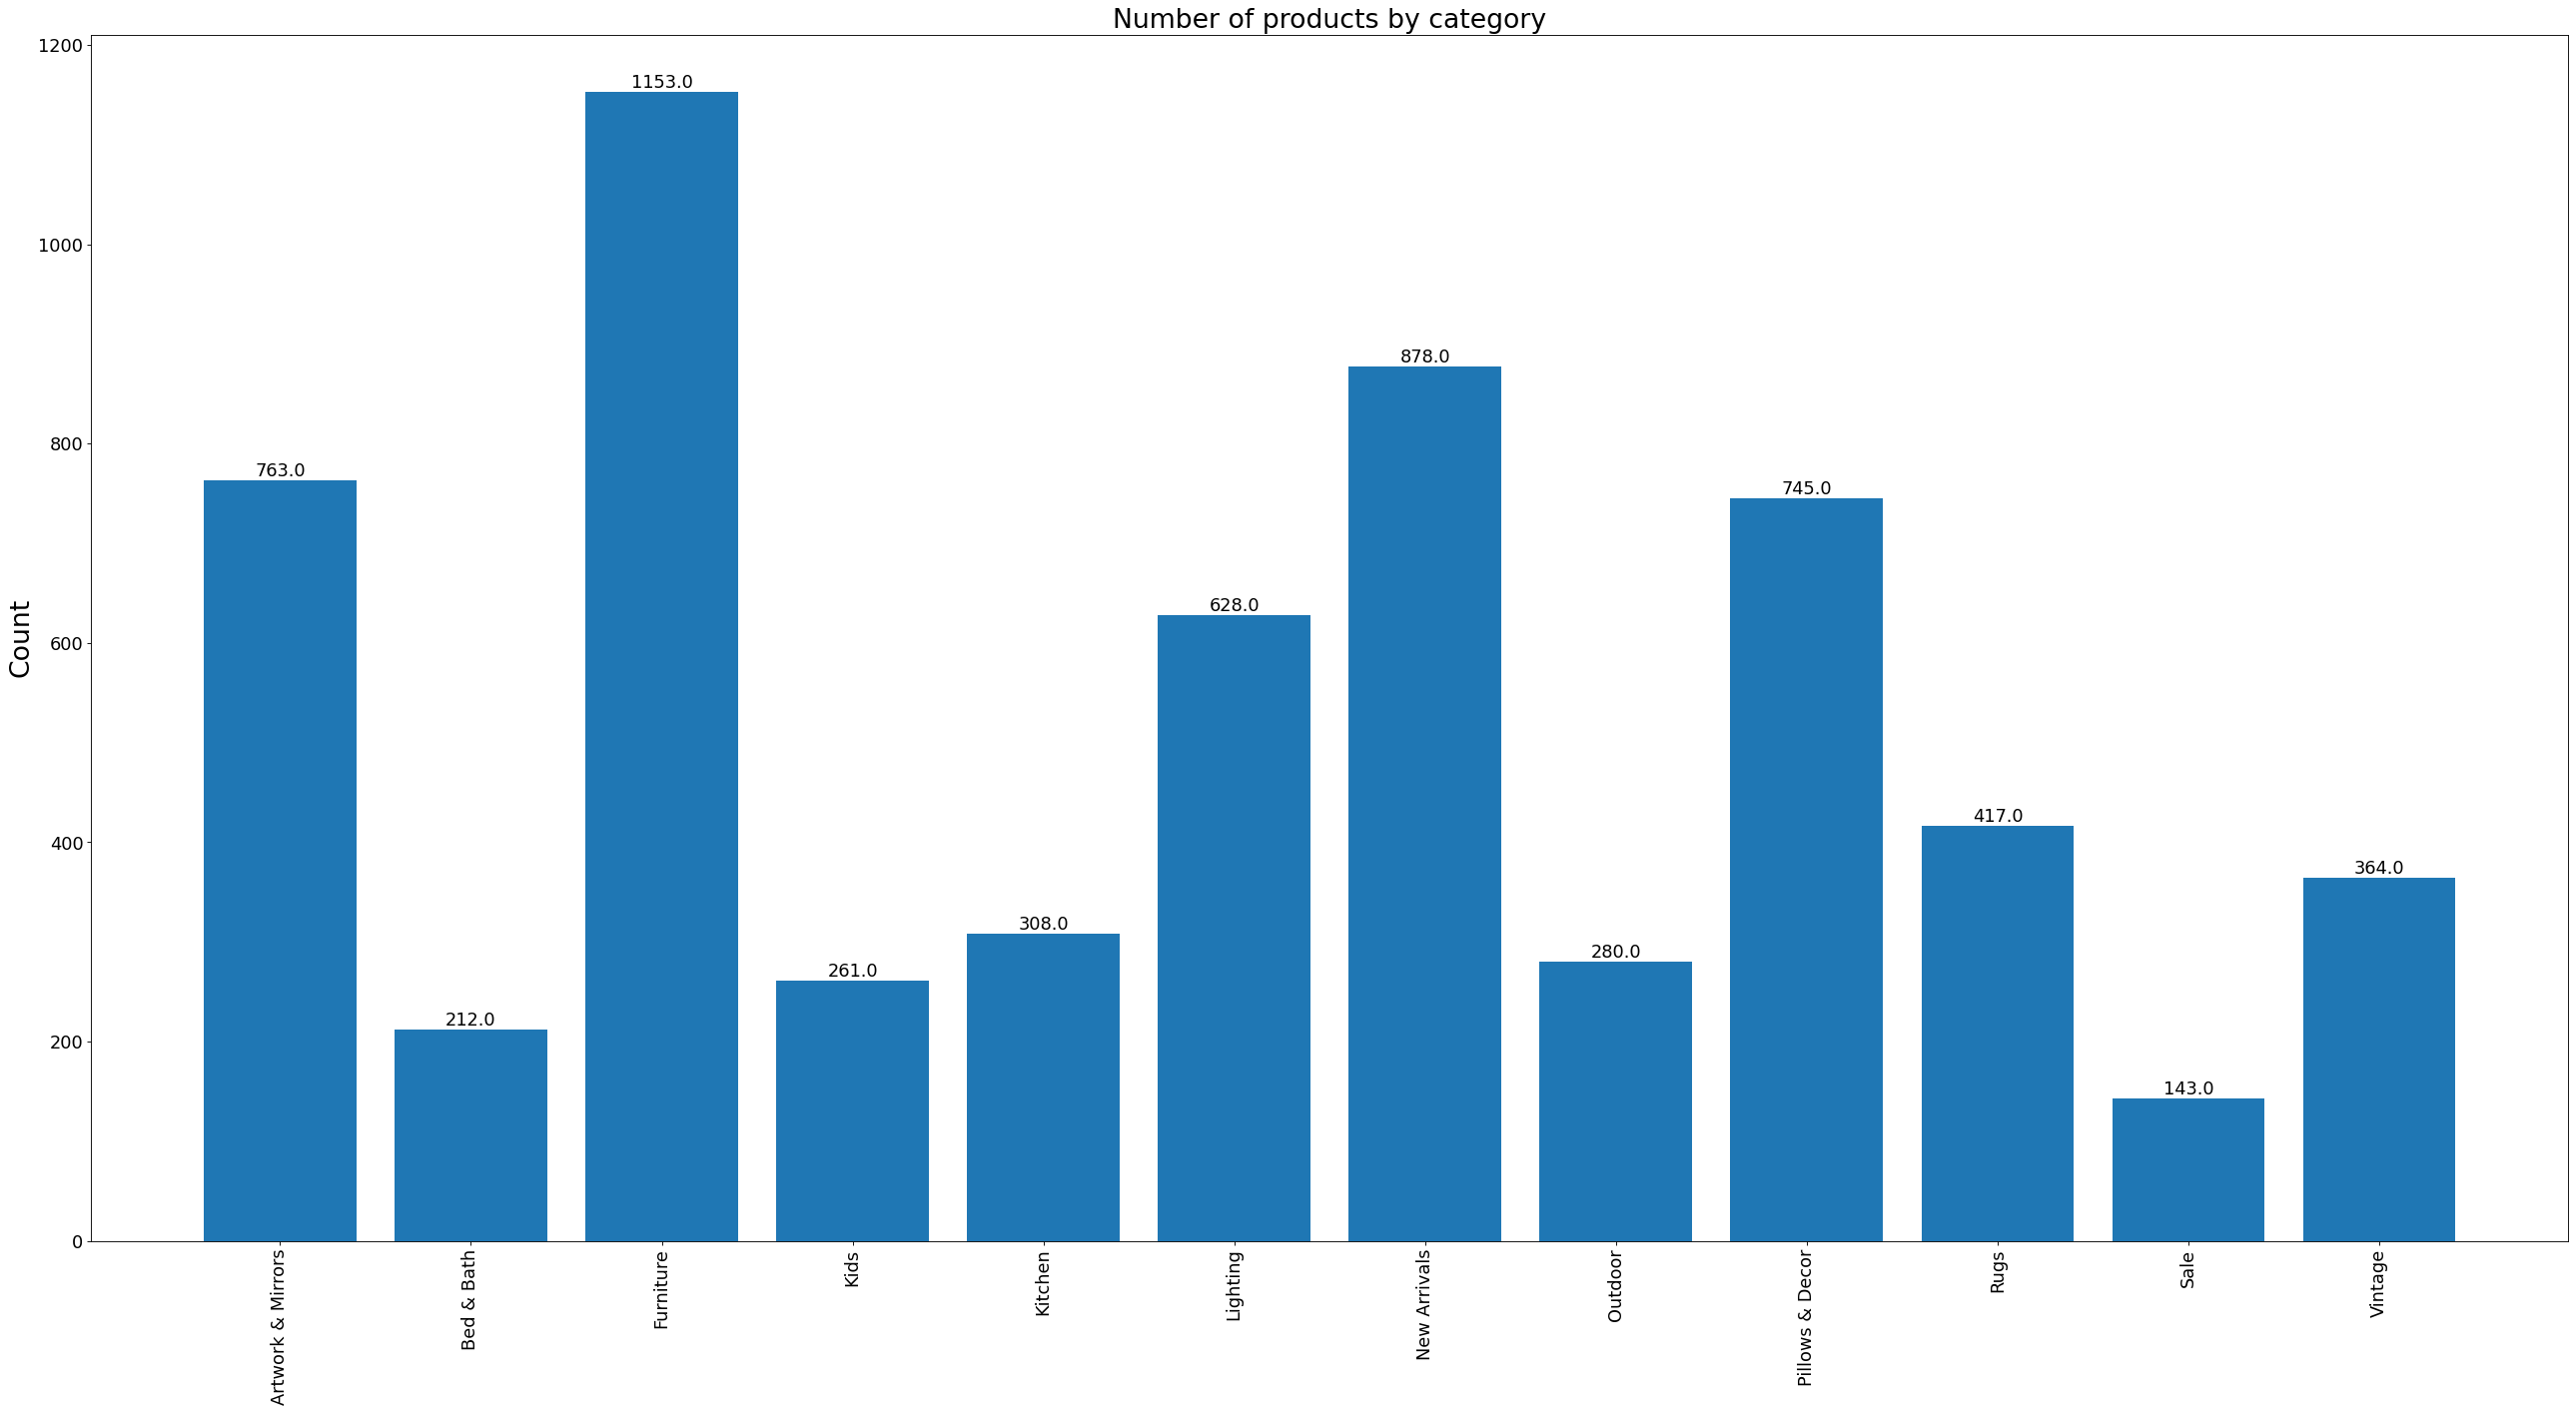

In [45]:
df = category_df.size().reset_index(name="counts")
c = df["counts"]
plot_bar(df["category"], df["counts"])
plt.title("Number of products by category", fontsize=24)

Text(0.5, 1.0, 'Number of products by subcategory')

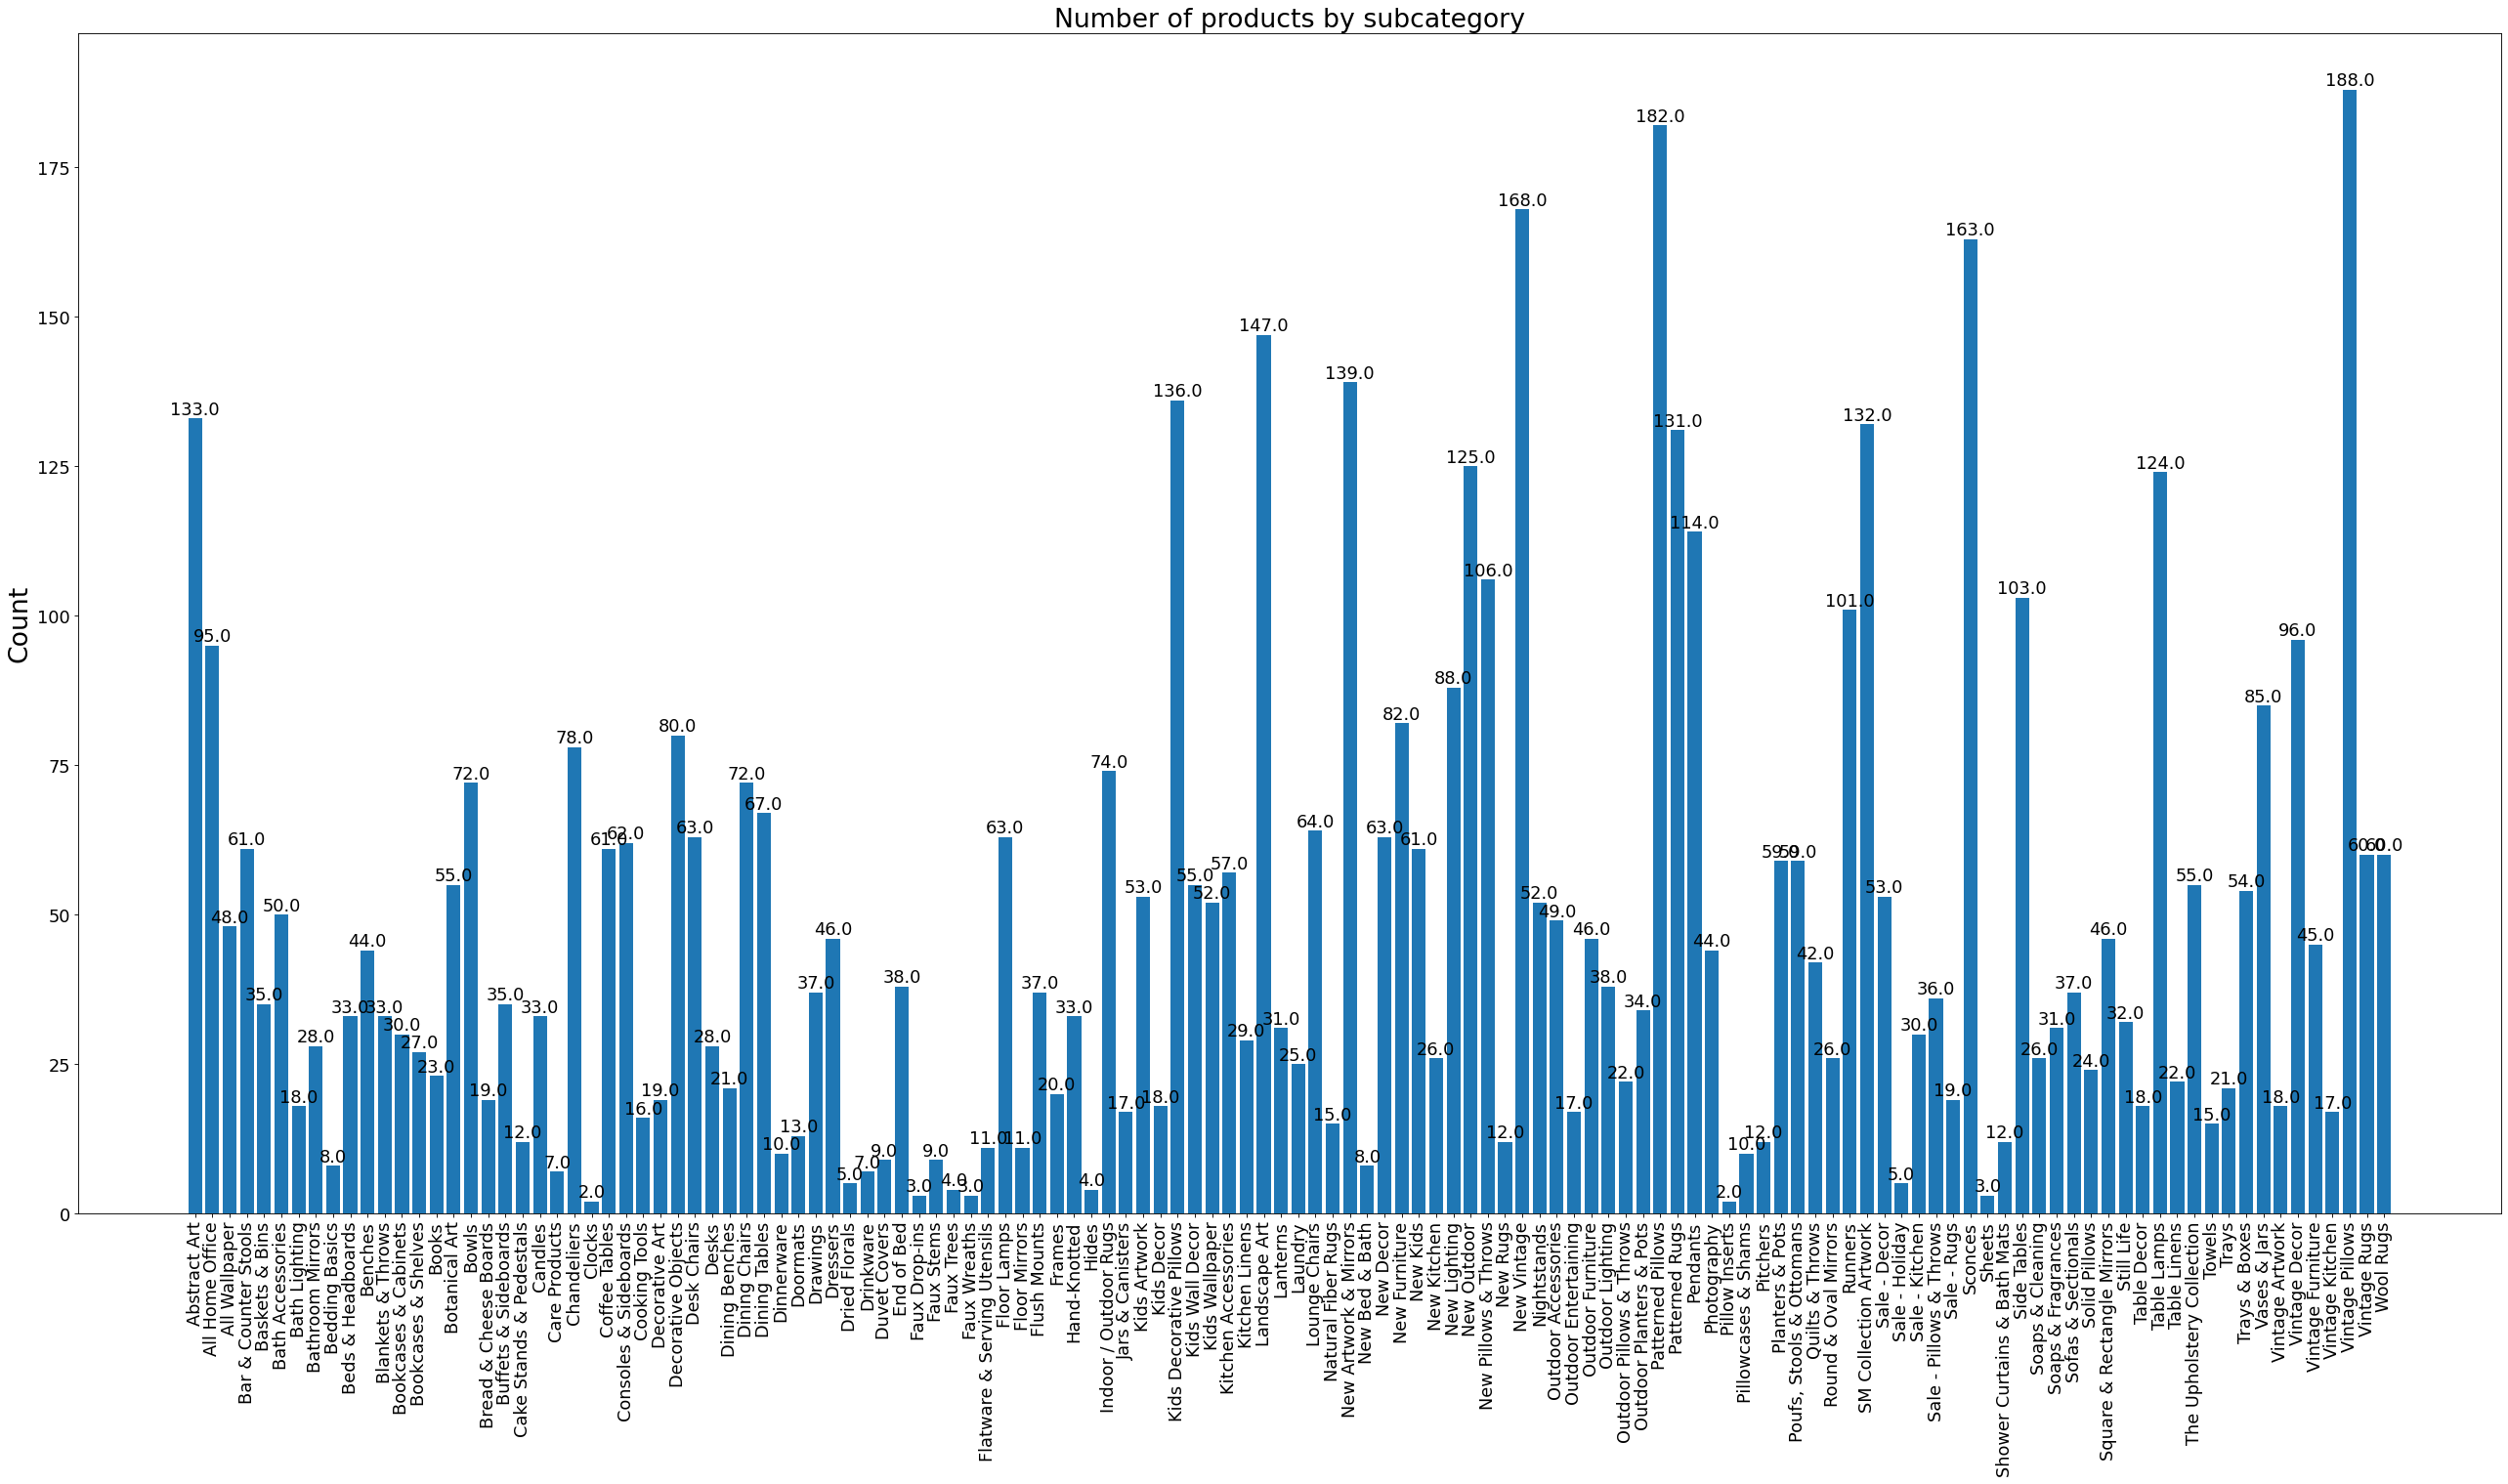

In [46]:
df = subcategory_df.size().reset_index(name="counts")
c = df["counts"]
plot_bar(df["subcategory"], df["counts"])
plt.title("Number of products by subcategory", fontsize=24)

Text(0.5, 1.0, 'Mean of products by category')

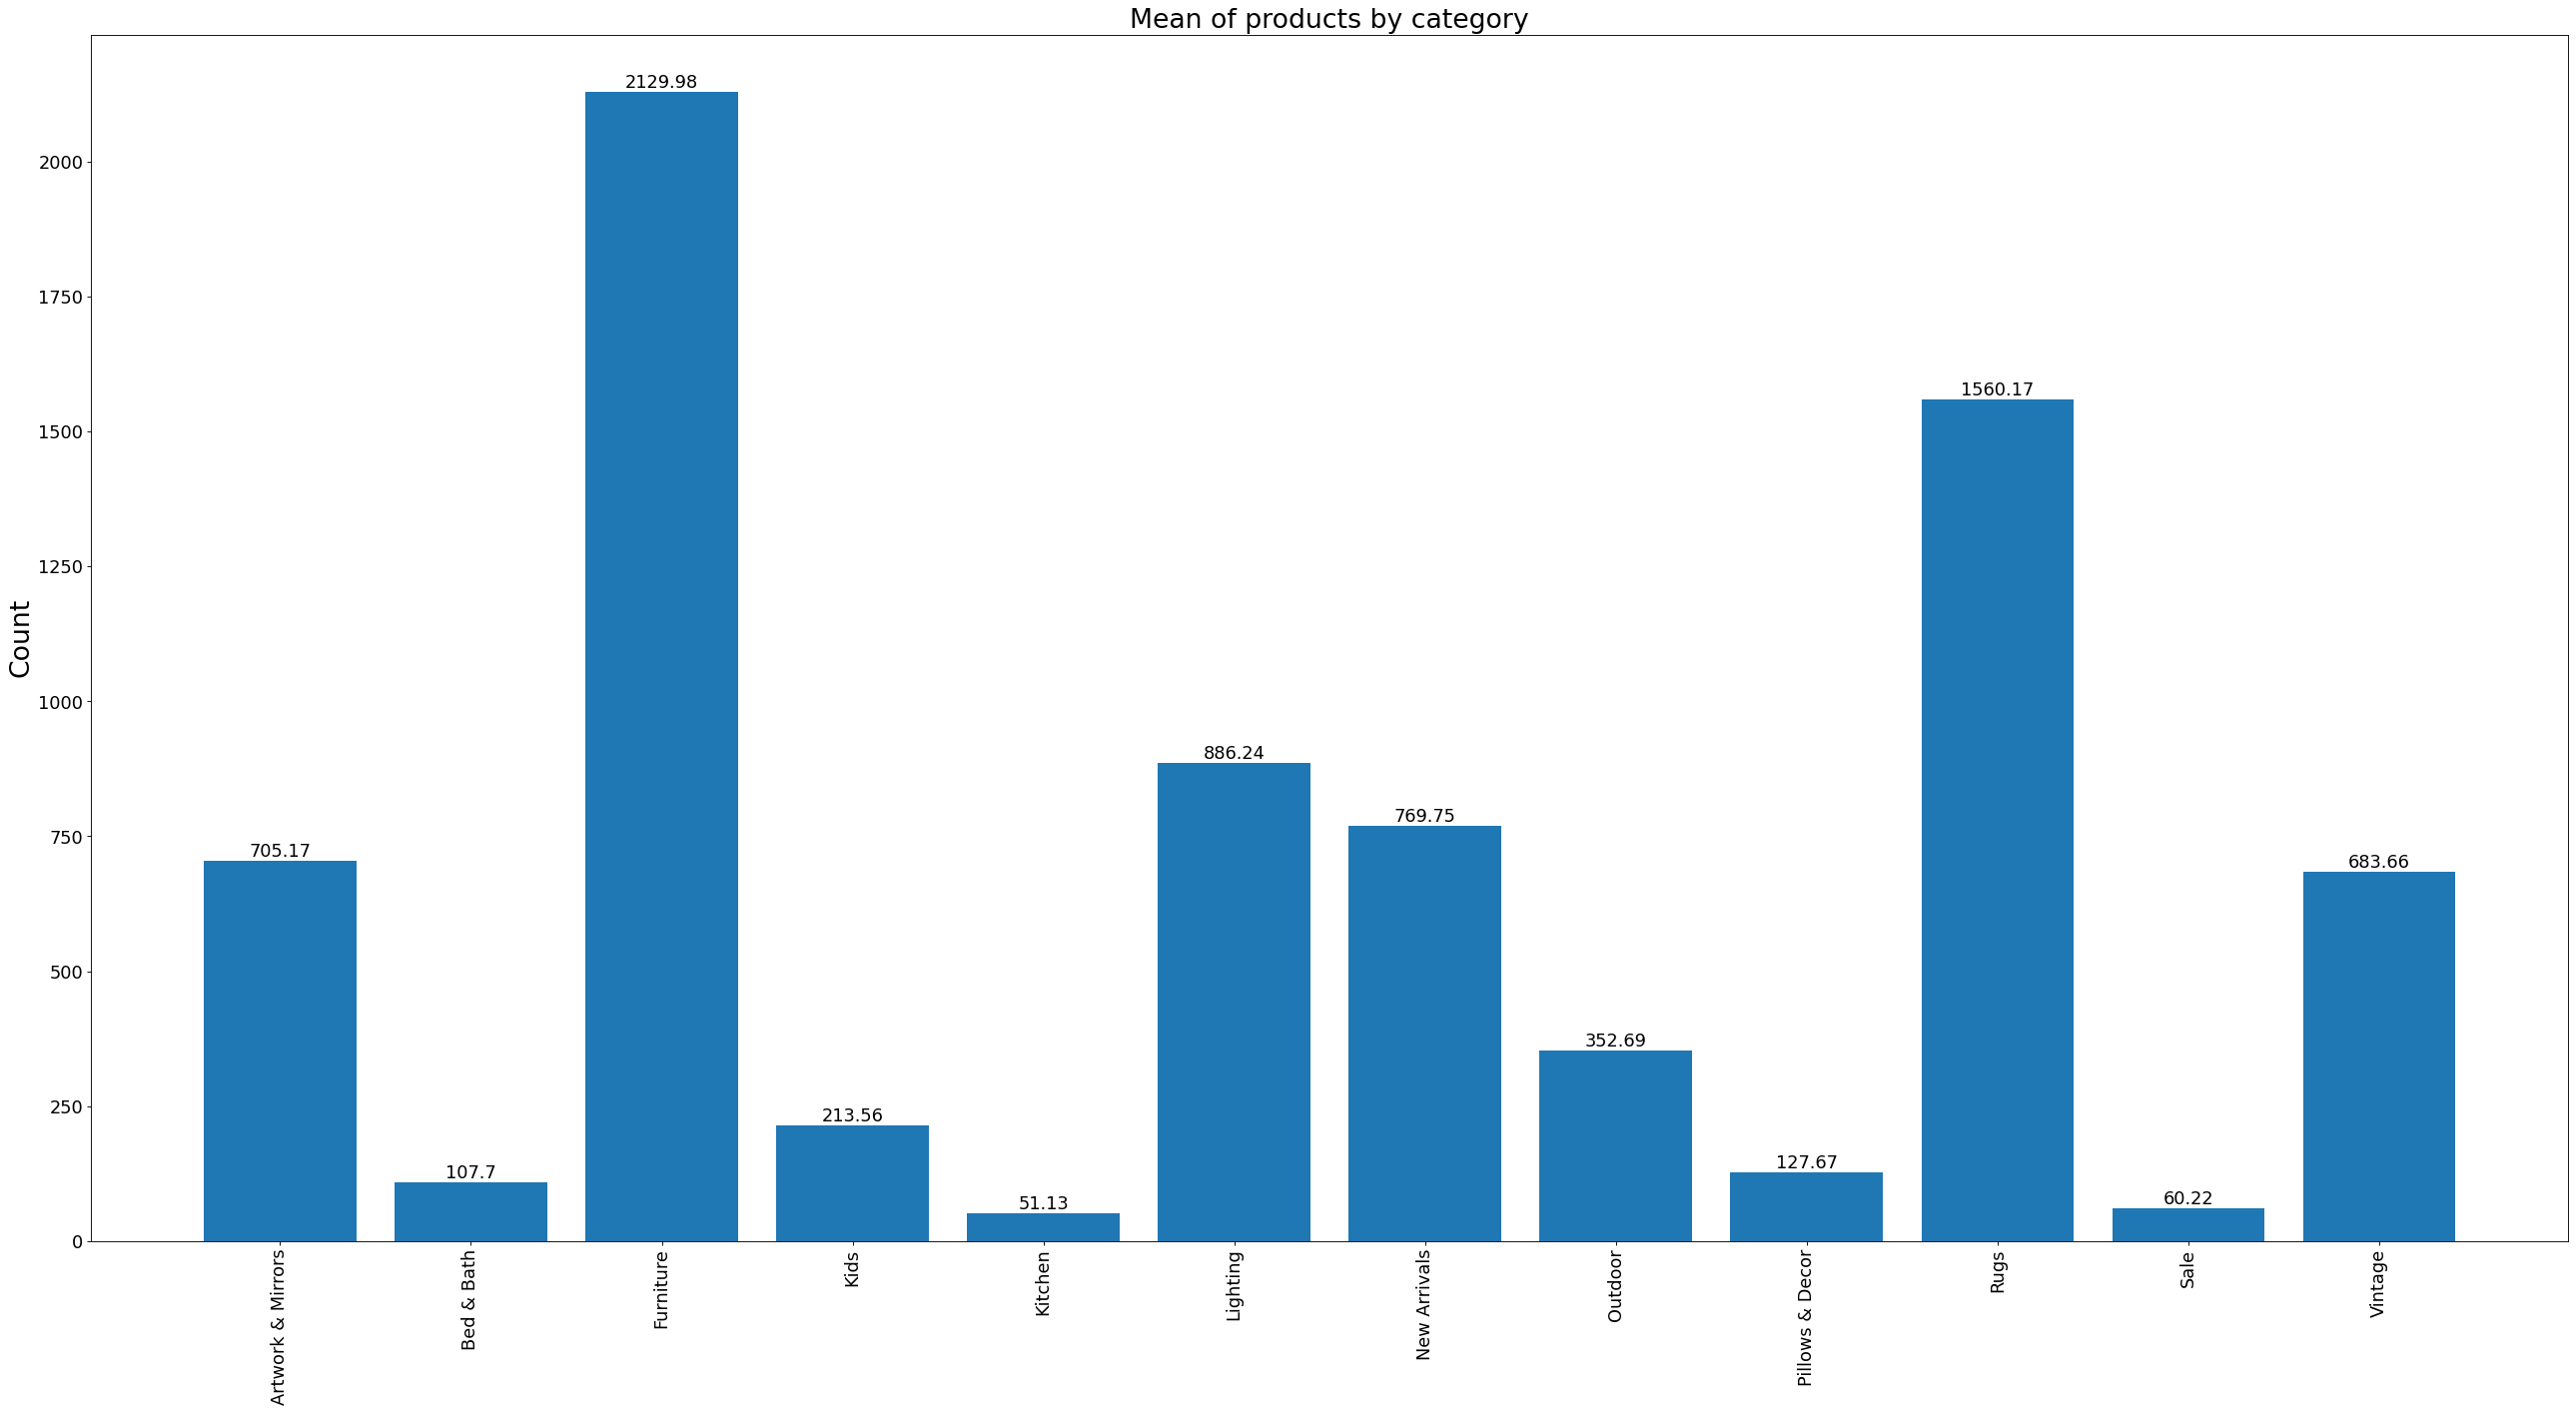

In [47]:
df = category_df.mean().reset_index()
c = df["price"].round(2)
plot_bar(df["category"], df["price"])
plt.title("Mean of products by category", fontsize=24)

Text(0.5, 1.0, 'Mean of products by subcategory')

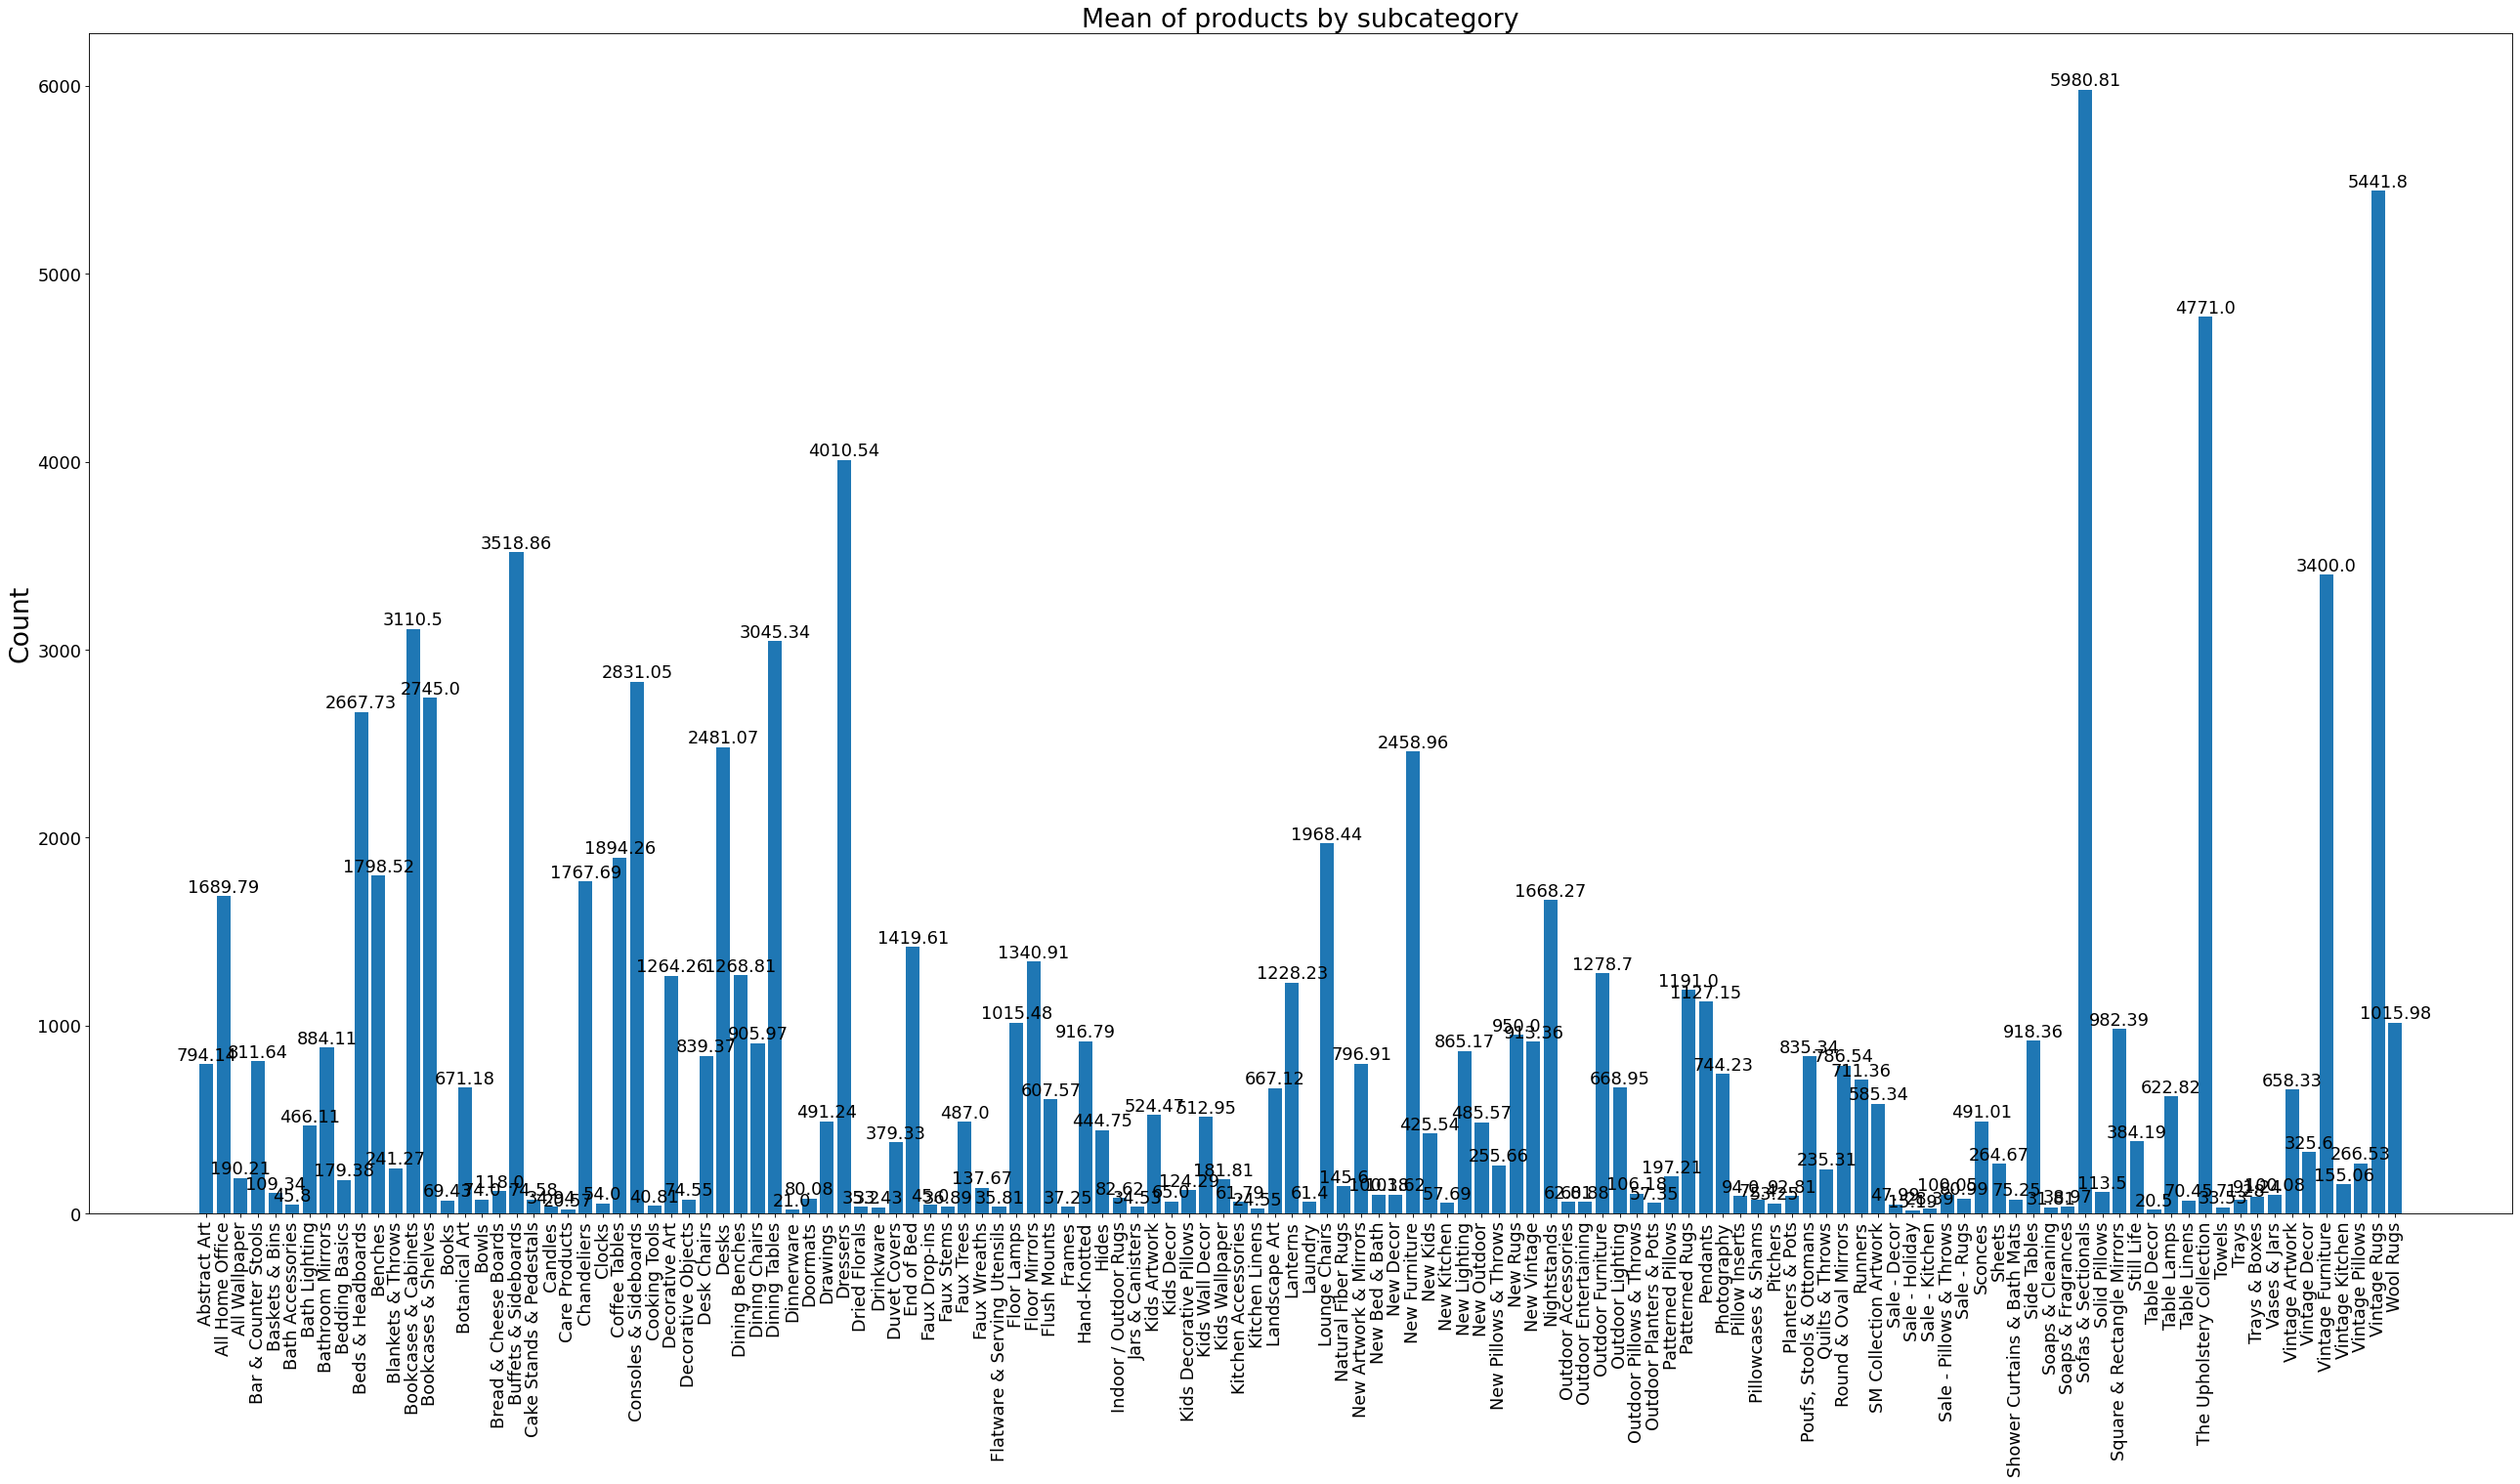

In [48]:
df = subcategory_df.mean().reset_index()
c = df["price"].round(2)
plot_bar(df["subcategory"], df["price"])
plt.title("Mean of products by subcategory", fontsize=24)

Text(0.5, 1.0, 'Median of products by category')

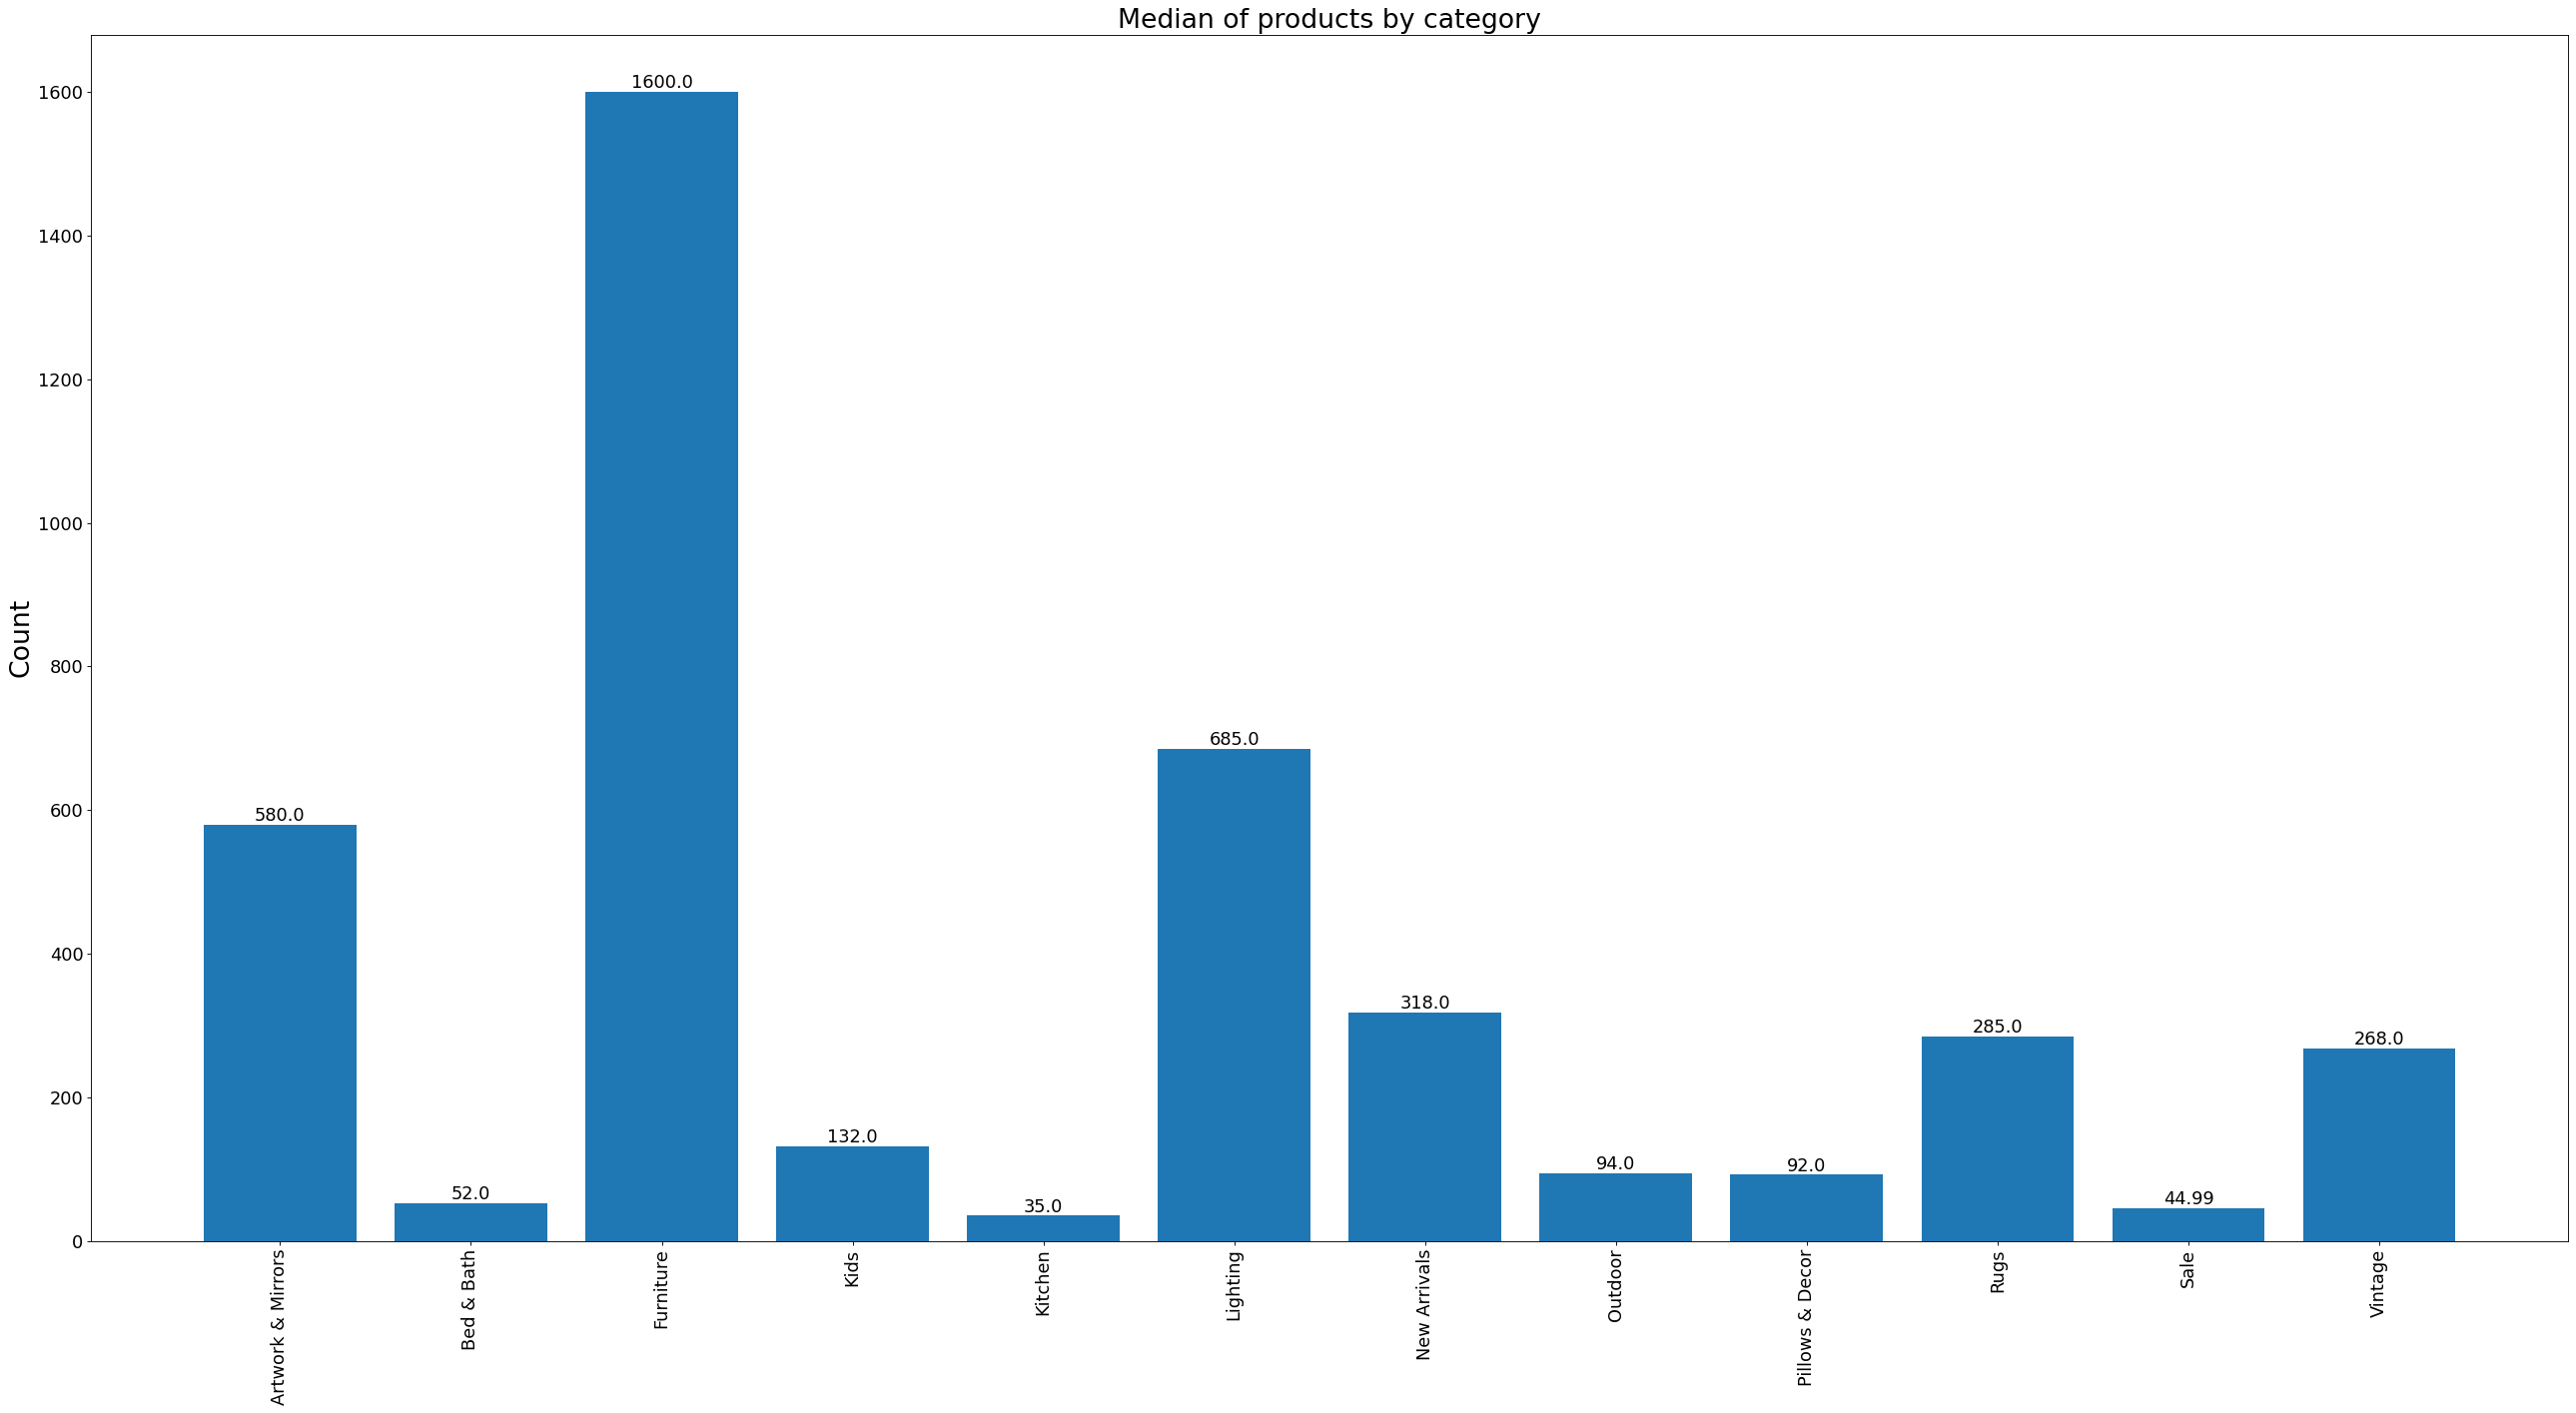

In [49]:
df = category_df.median().reset_index()
c = df["price"].round(2)
plot_bar(df["category"], df["price"])
plt.title("Median of products by category", fontsize=24)

Text(0.5, 1.0, 'Median of products by subcategory')

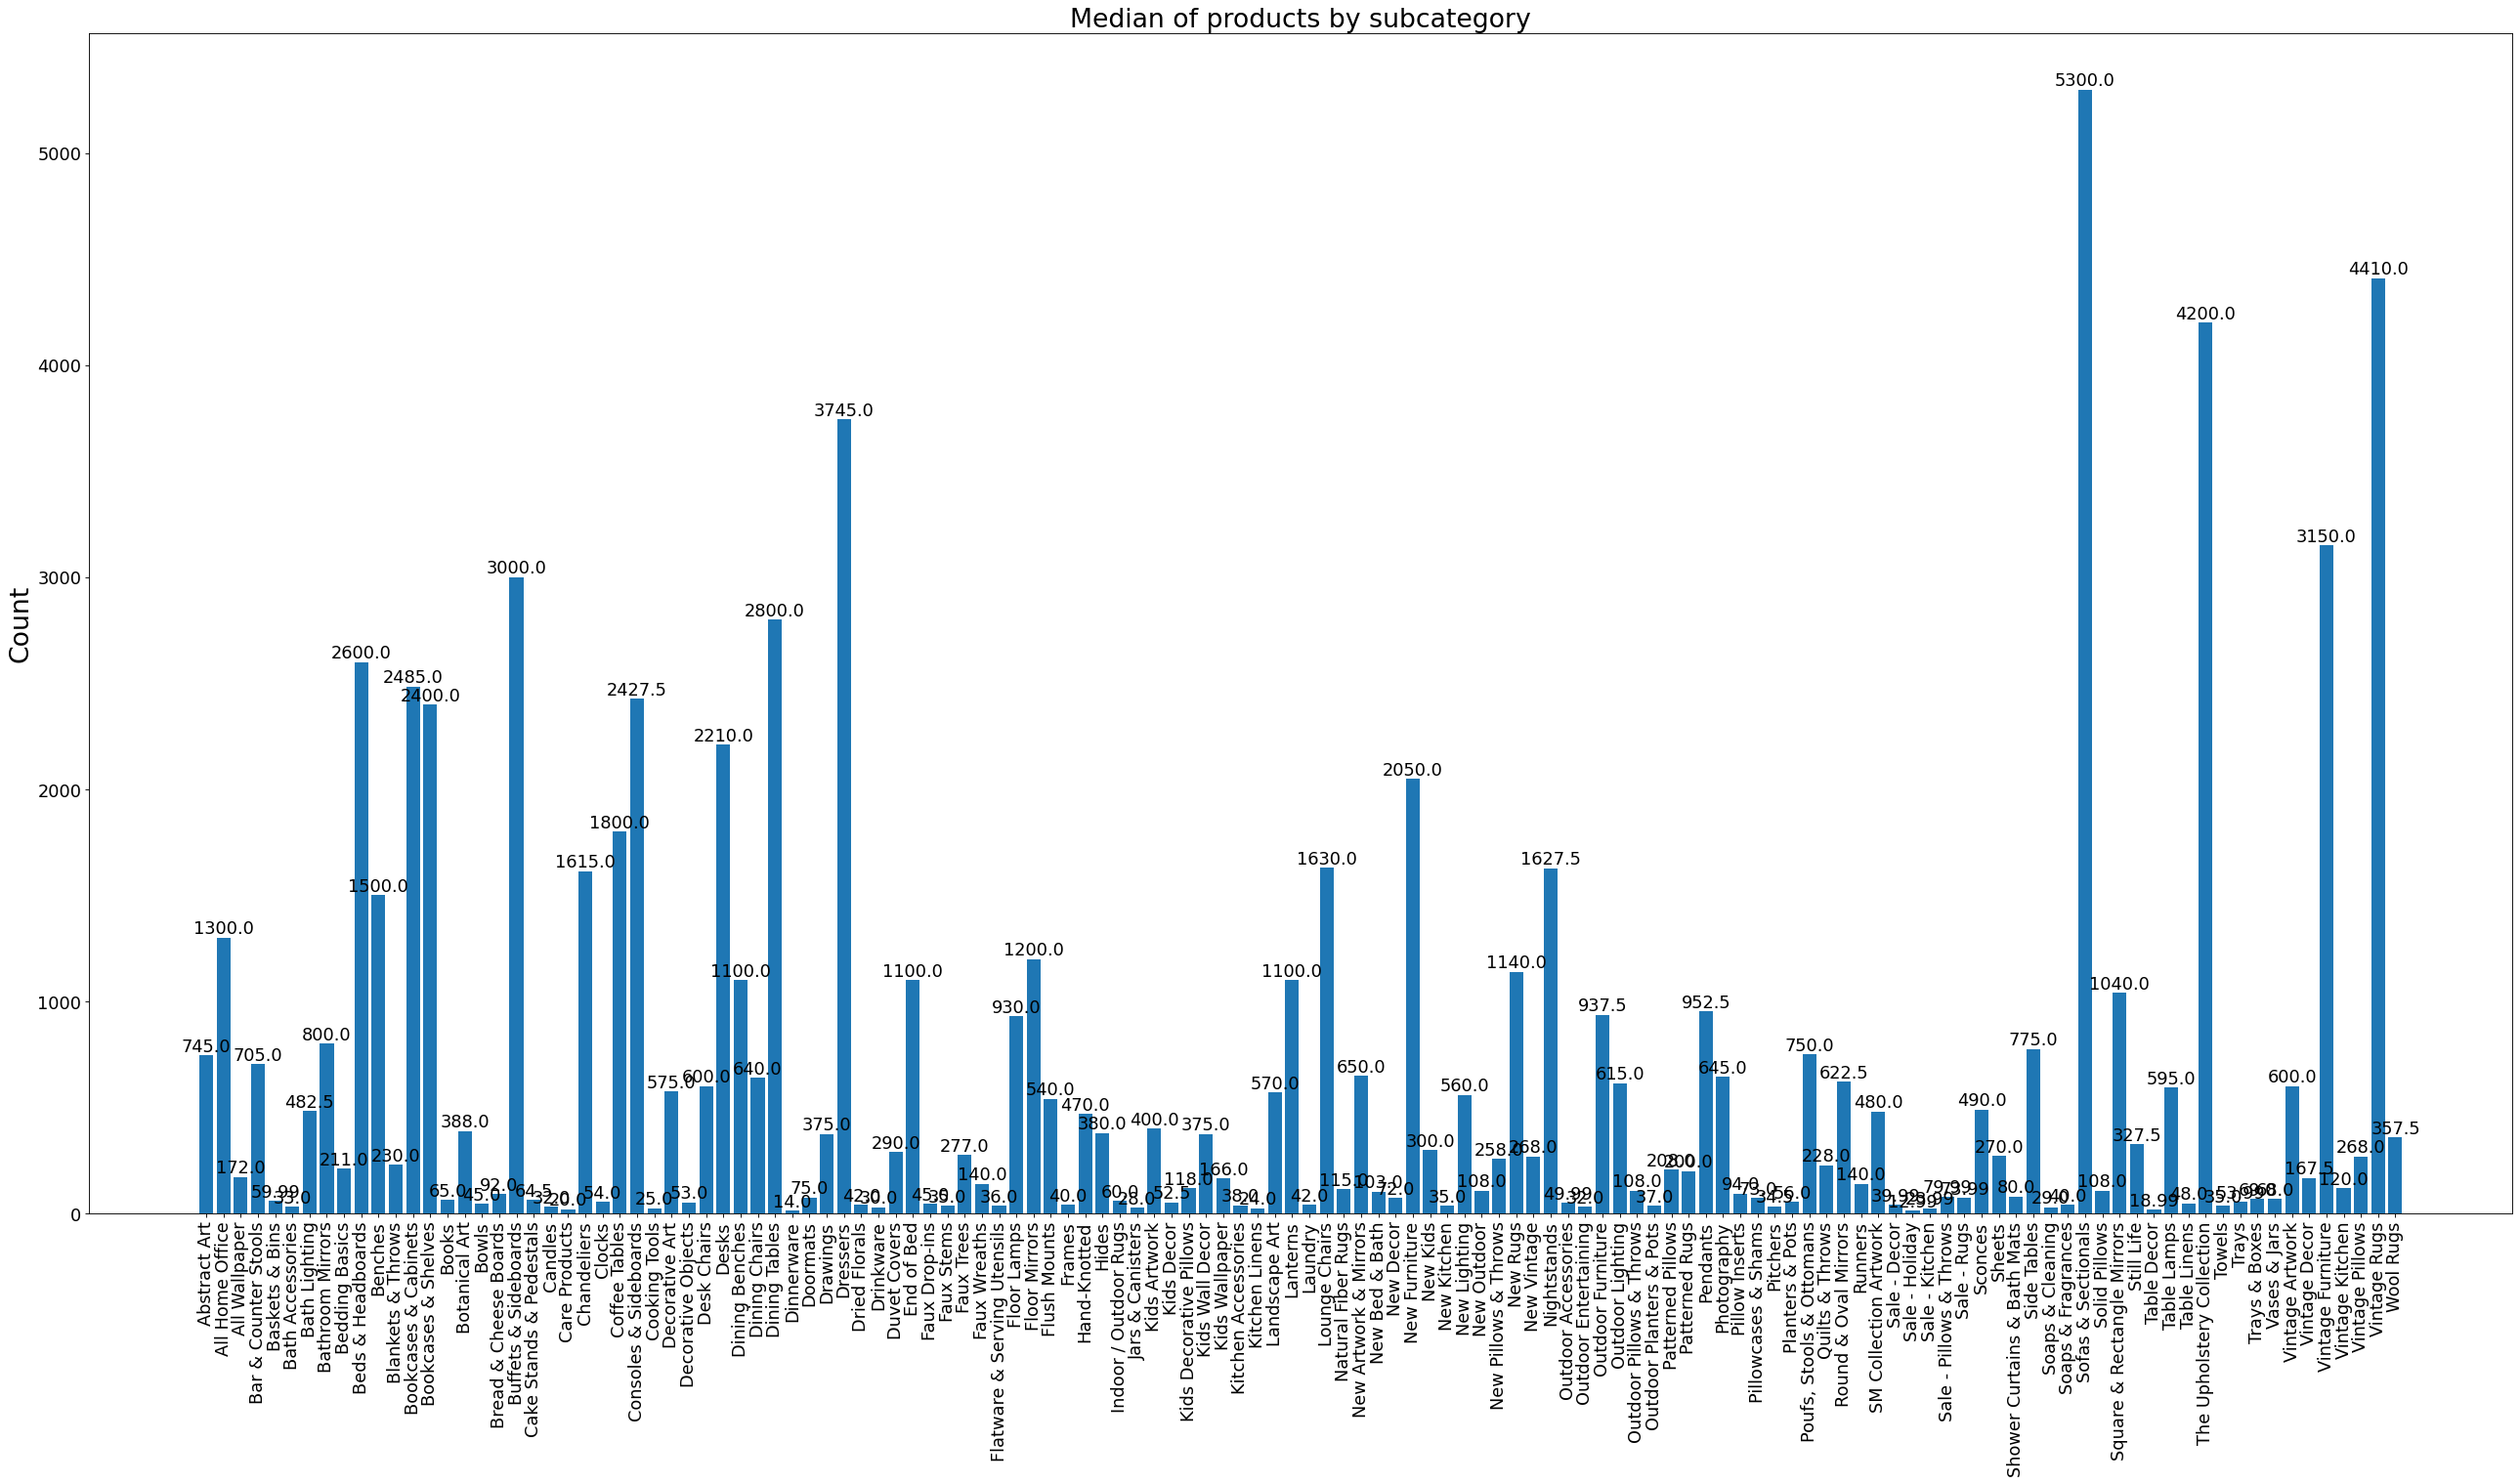

In [50]:
df = subcategory_df.median().reset_index()
c = df["price"].round(2)
plot_bar(df["subcategory"], df["price"])
plt.title("Median of products by subcategory", fontsize=24)

In [51]:
purchase_no = dataset[dataset["purchase_opportunity"] == "No"]

Text(0.5, 1.0, 'Count of products by category wich is not available for purchase')

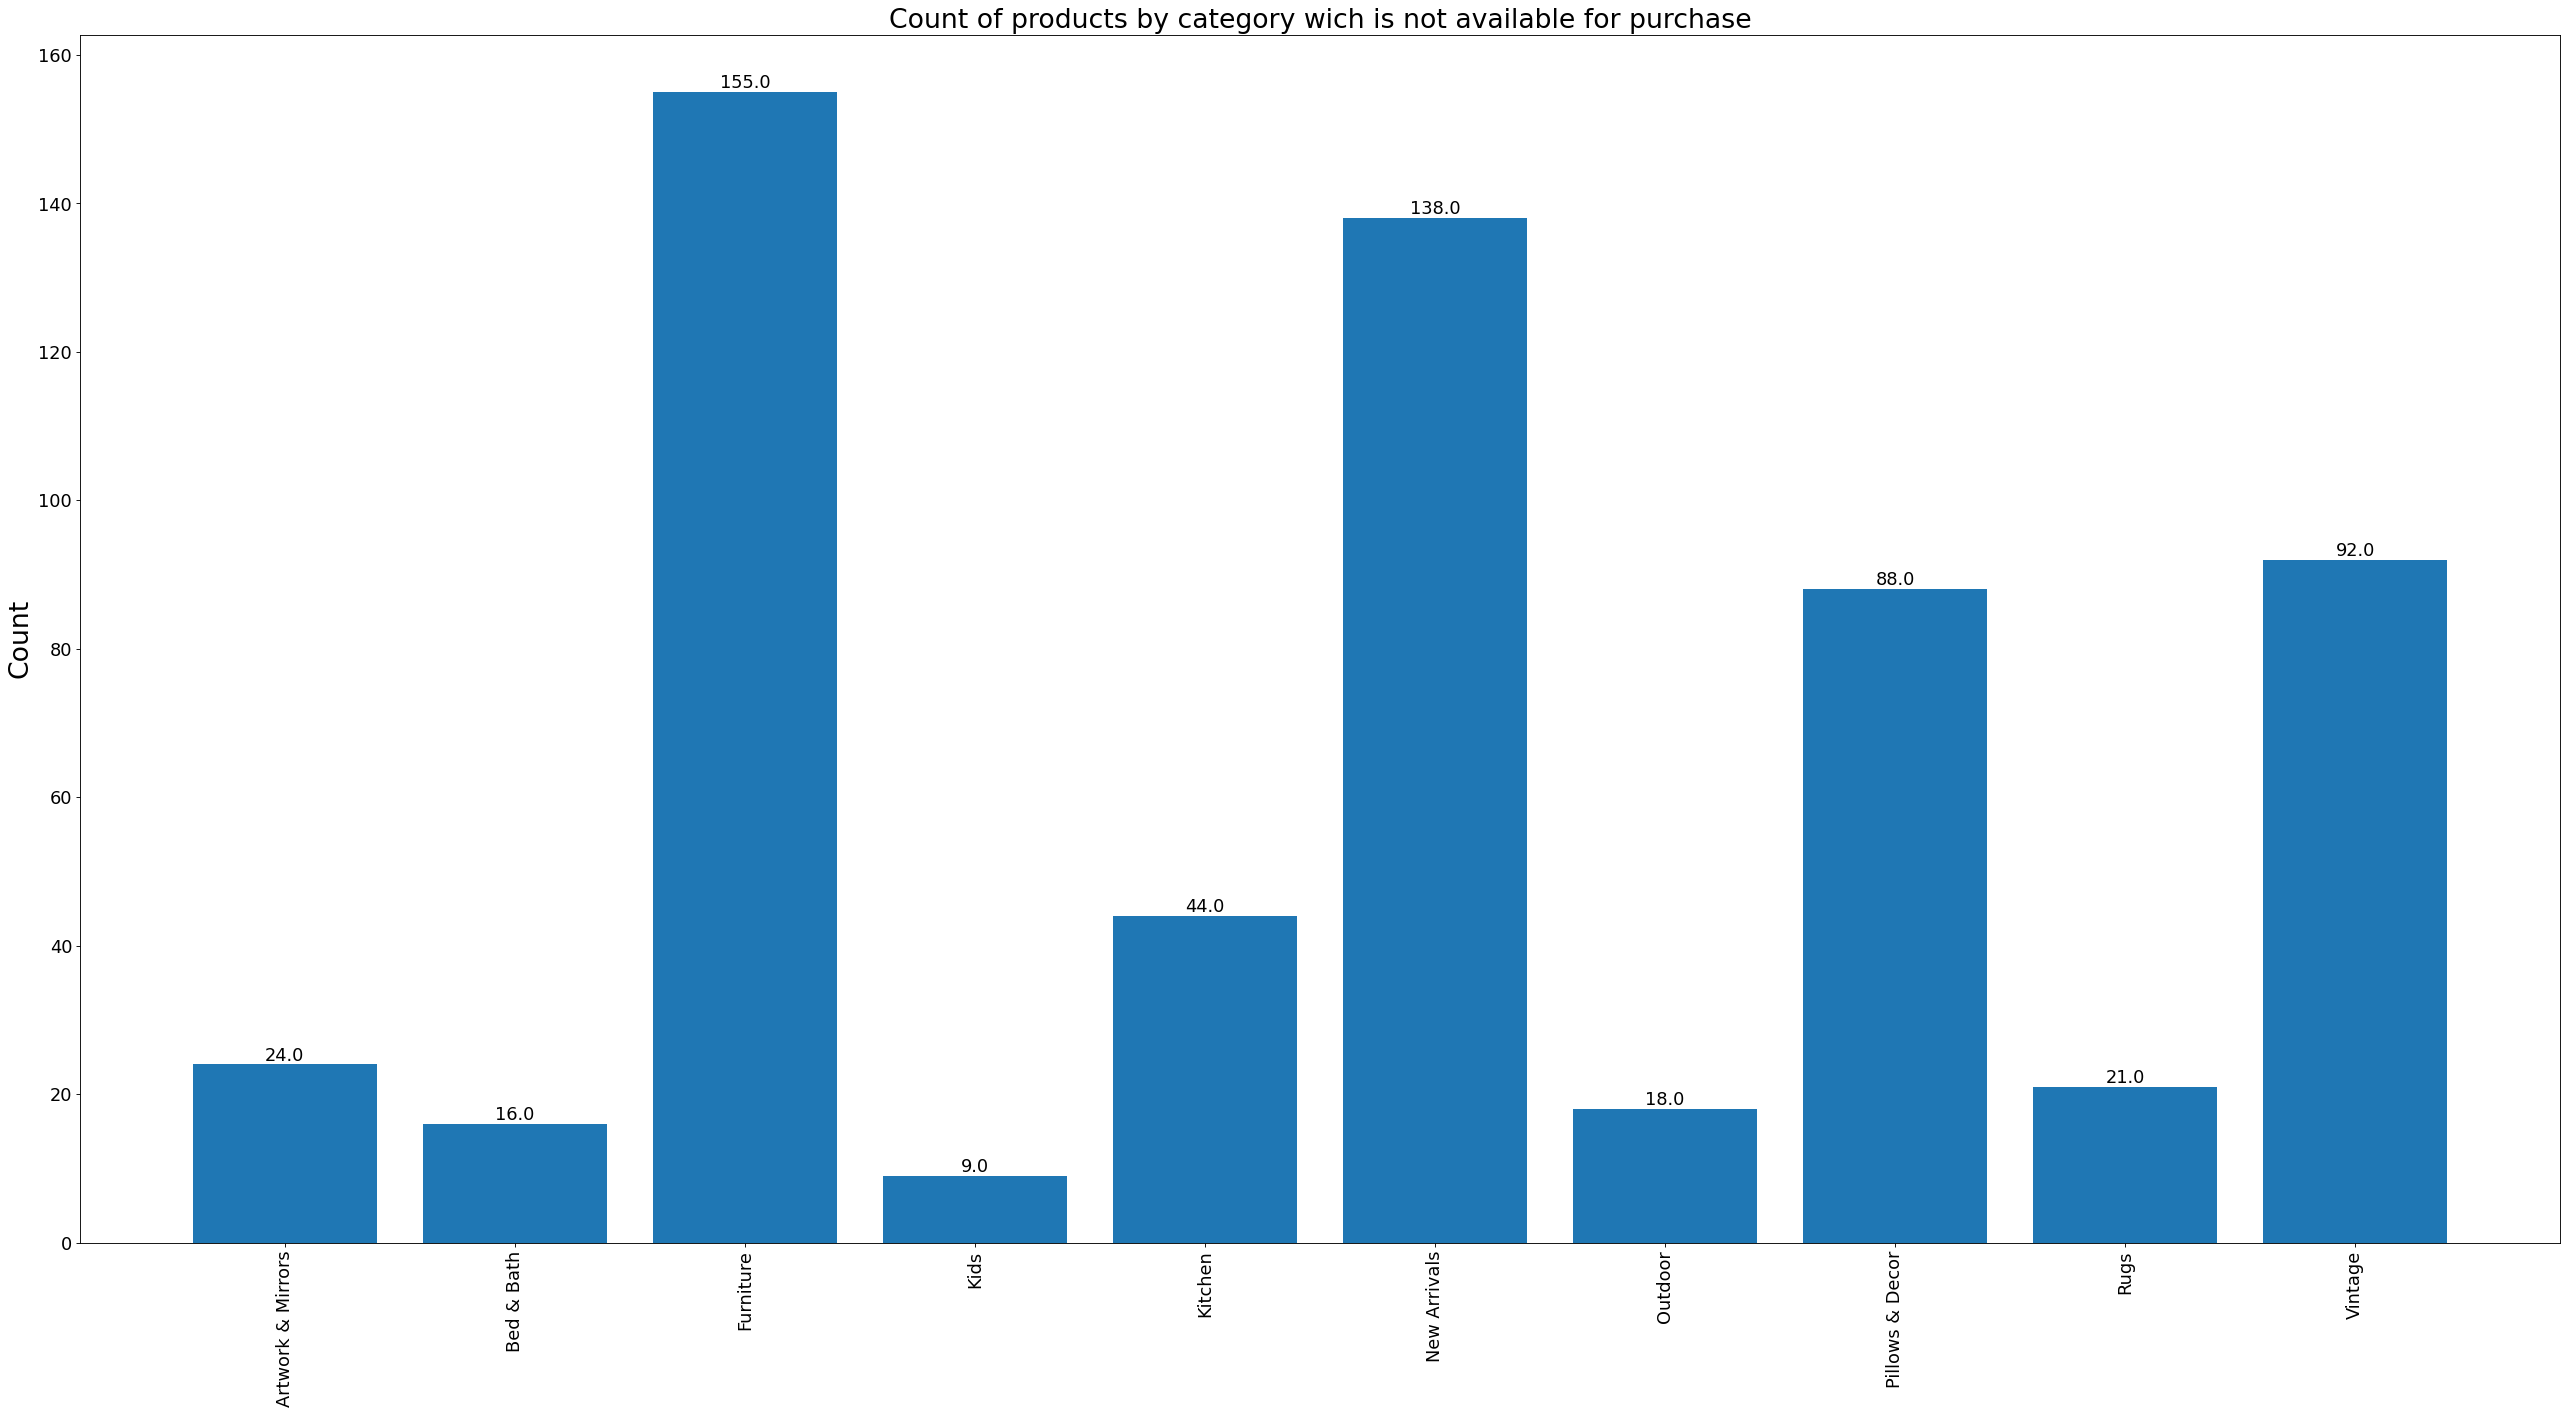

In [52]:
df = purchase_no.groupby("category").size().reset_index(name="counts")
c = df["counts"]
plot_bar(df["category"], df["counts"])
plt.title("Count of products by category wich is not available for purchase", fontsize=24)

Text(0.5, 1.0, 'Count of products by subcategory wich is not available for purchase')

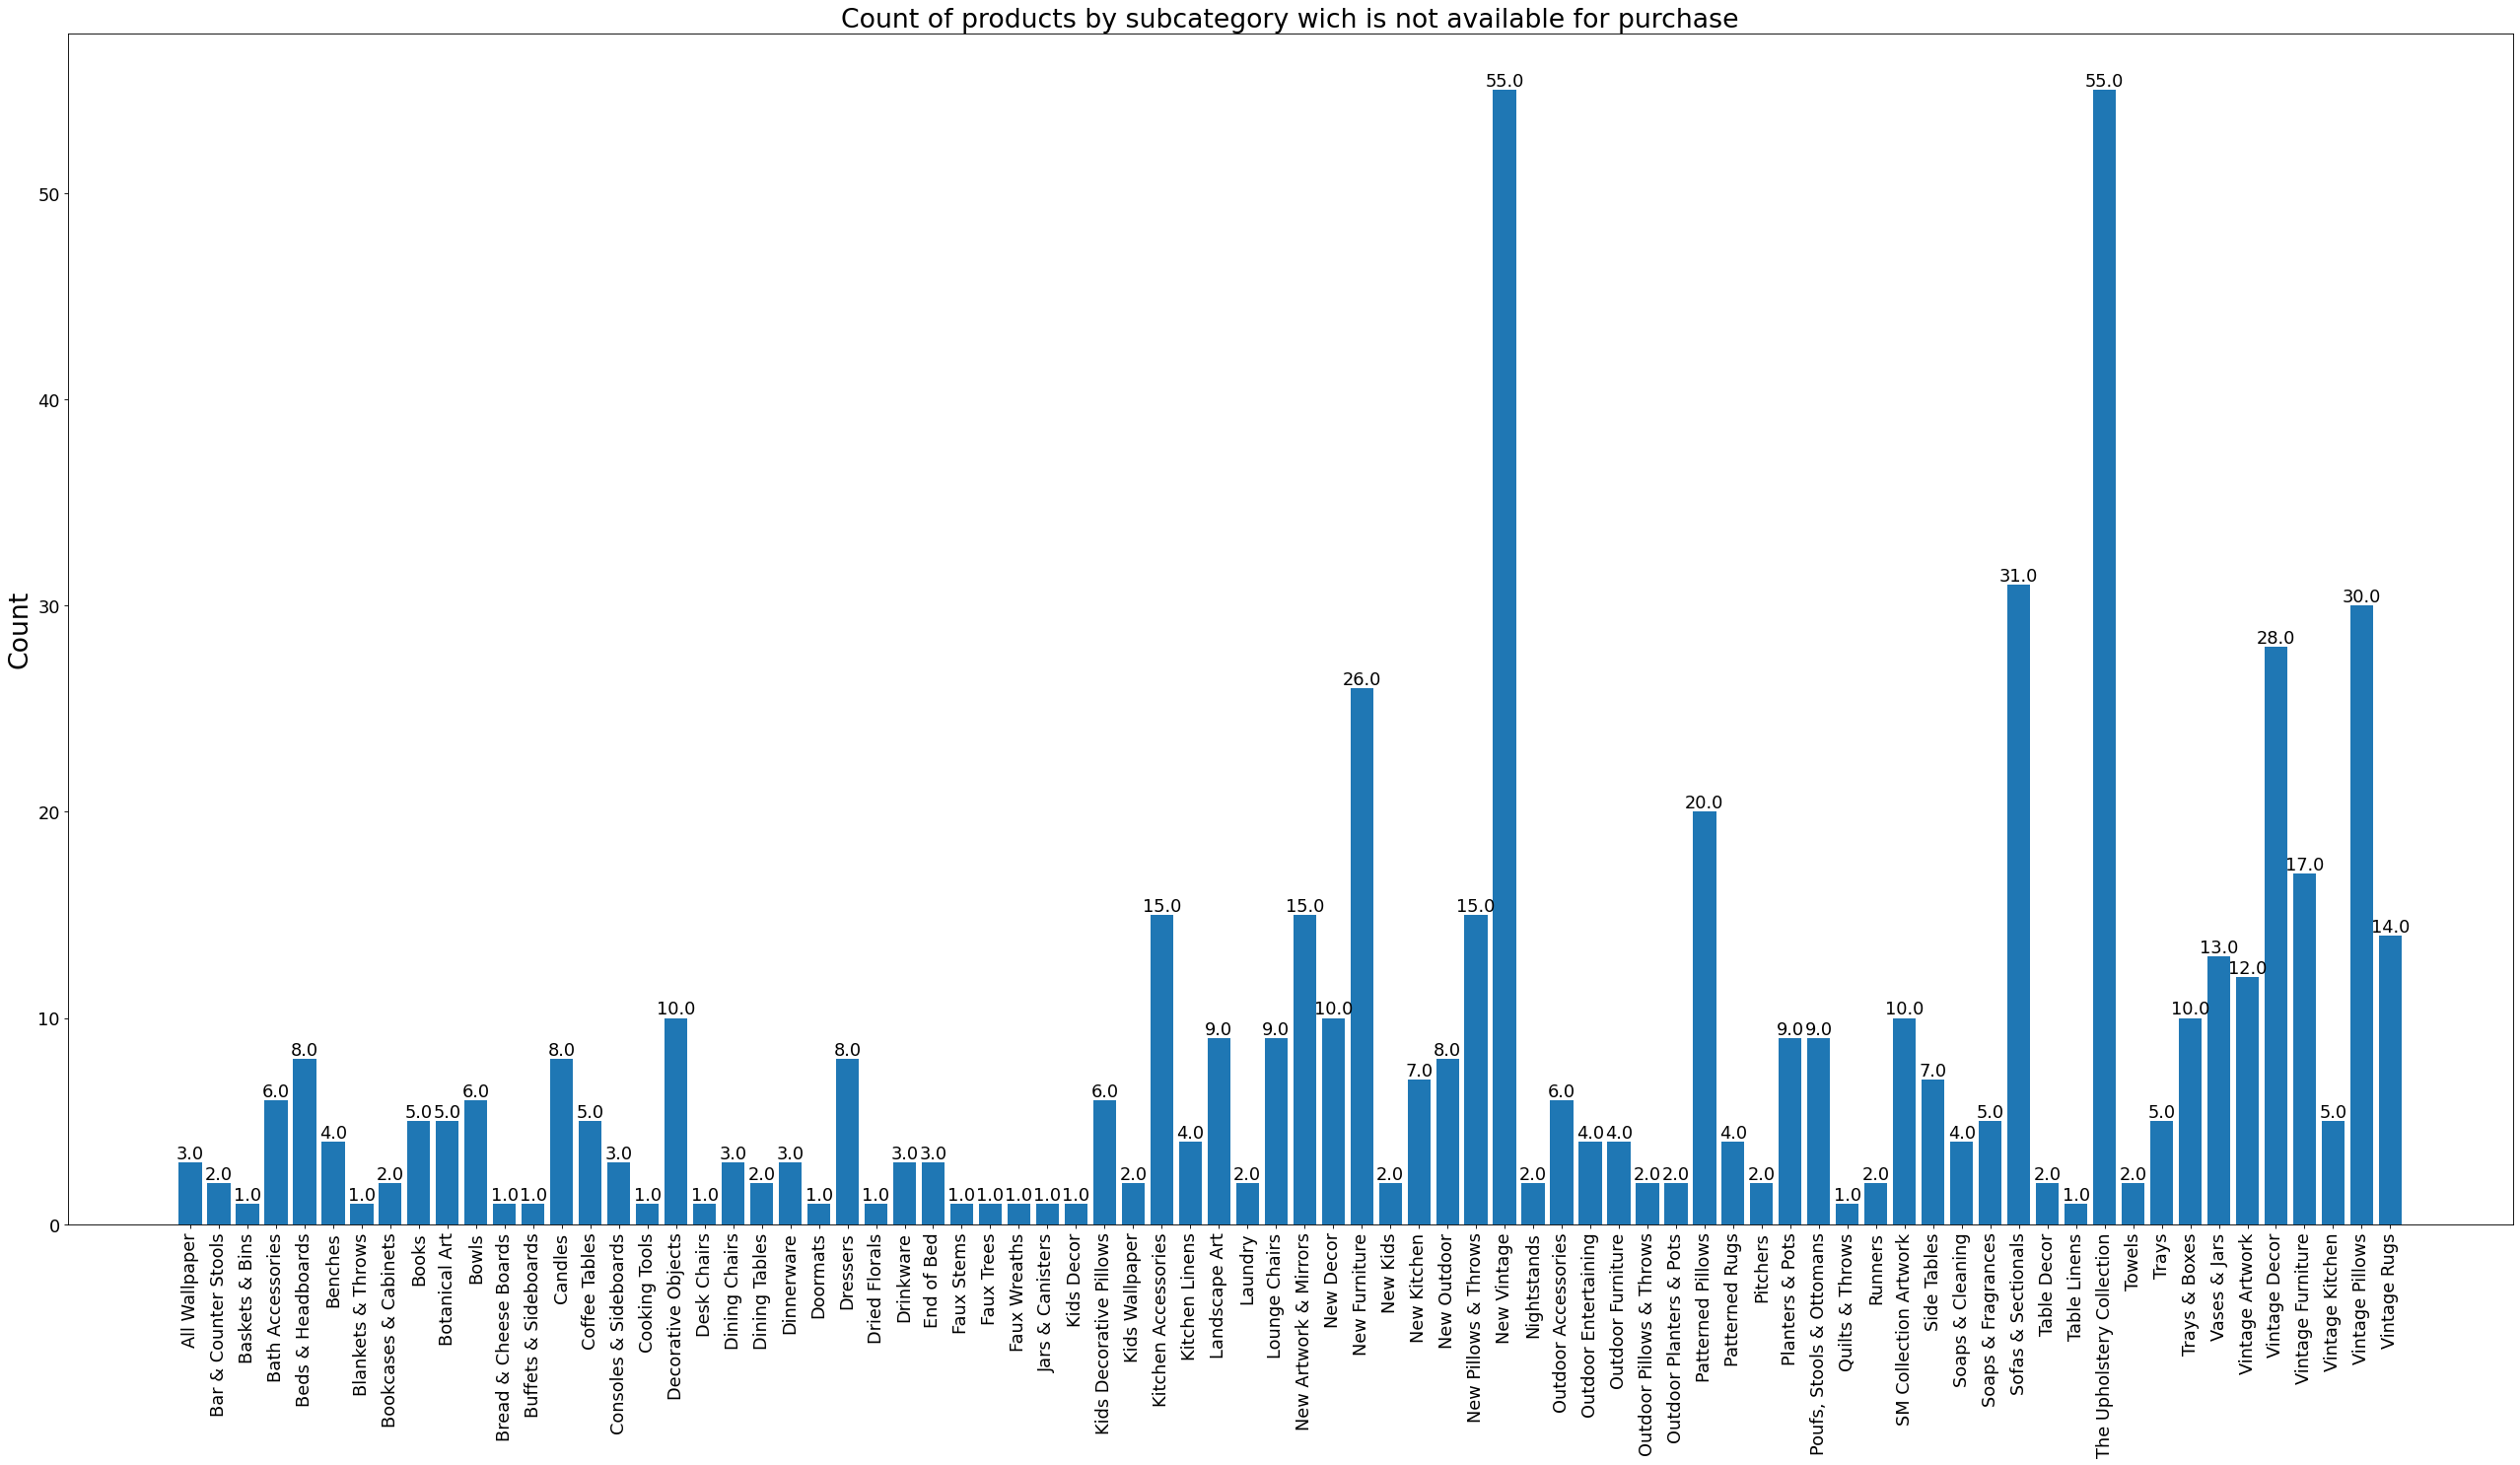

In [53]:
df = purchase_no.groupby("subcategory").size().reset_index(name="counts")
c = df["counts"]
plot_bar(df["subcategory"], df["counts"])
plt.title("Count of products by subcategory wich is not available for purchase", fontsize=24)

In [54]:
date_picker = "2021-05-01"
date_condition = dataset[dataset["created_at"] < date_picker]

Text(0.5, 1.0, 'Count of products by category wich exist on the 2021-05-01')

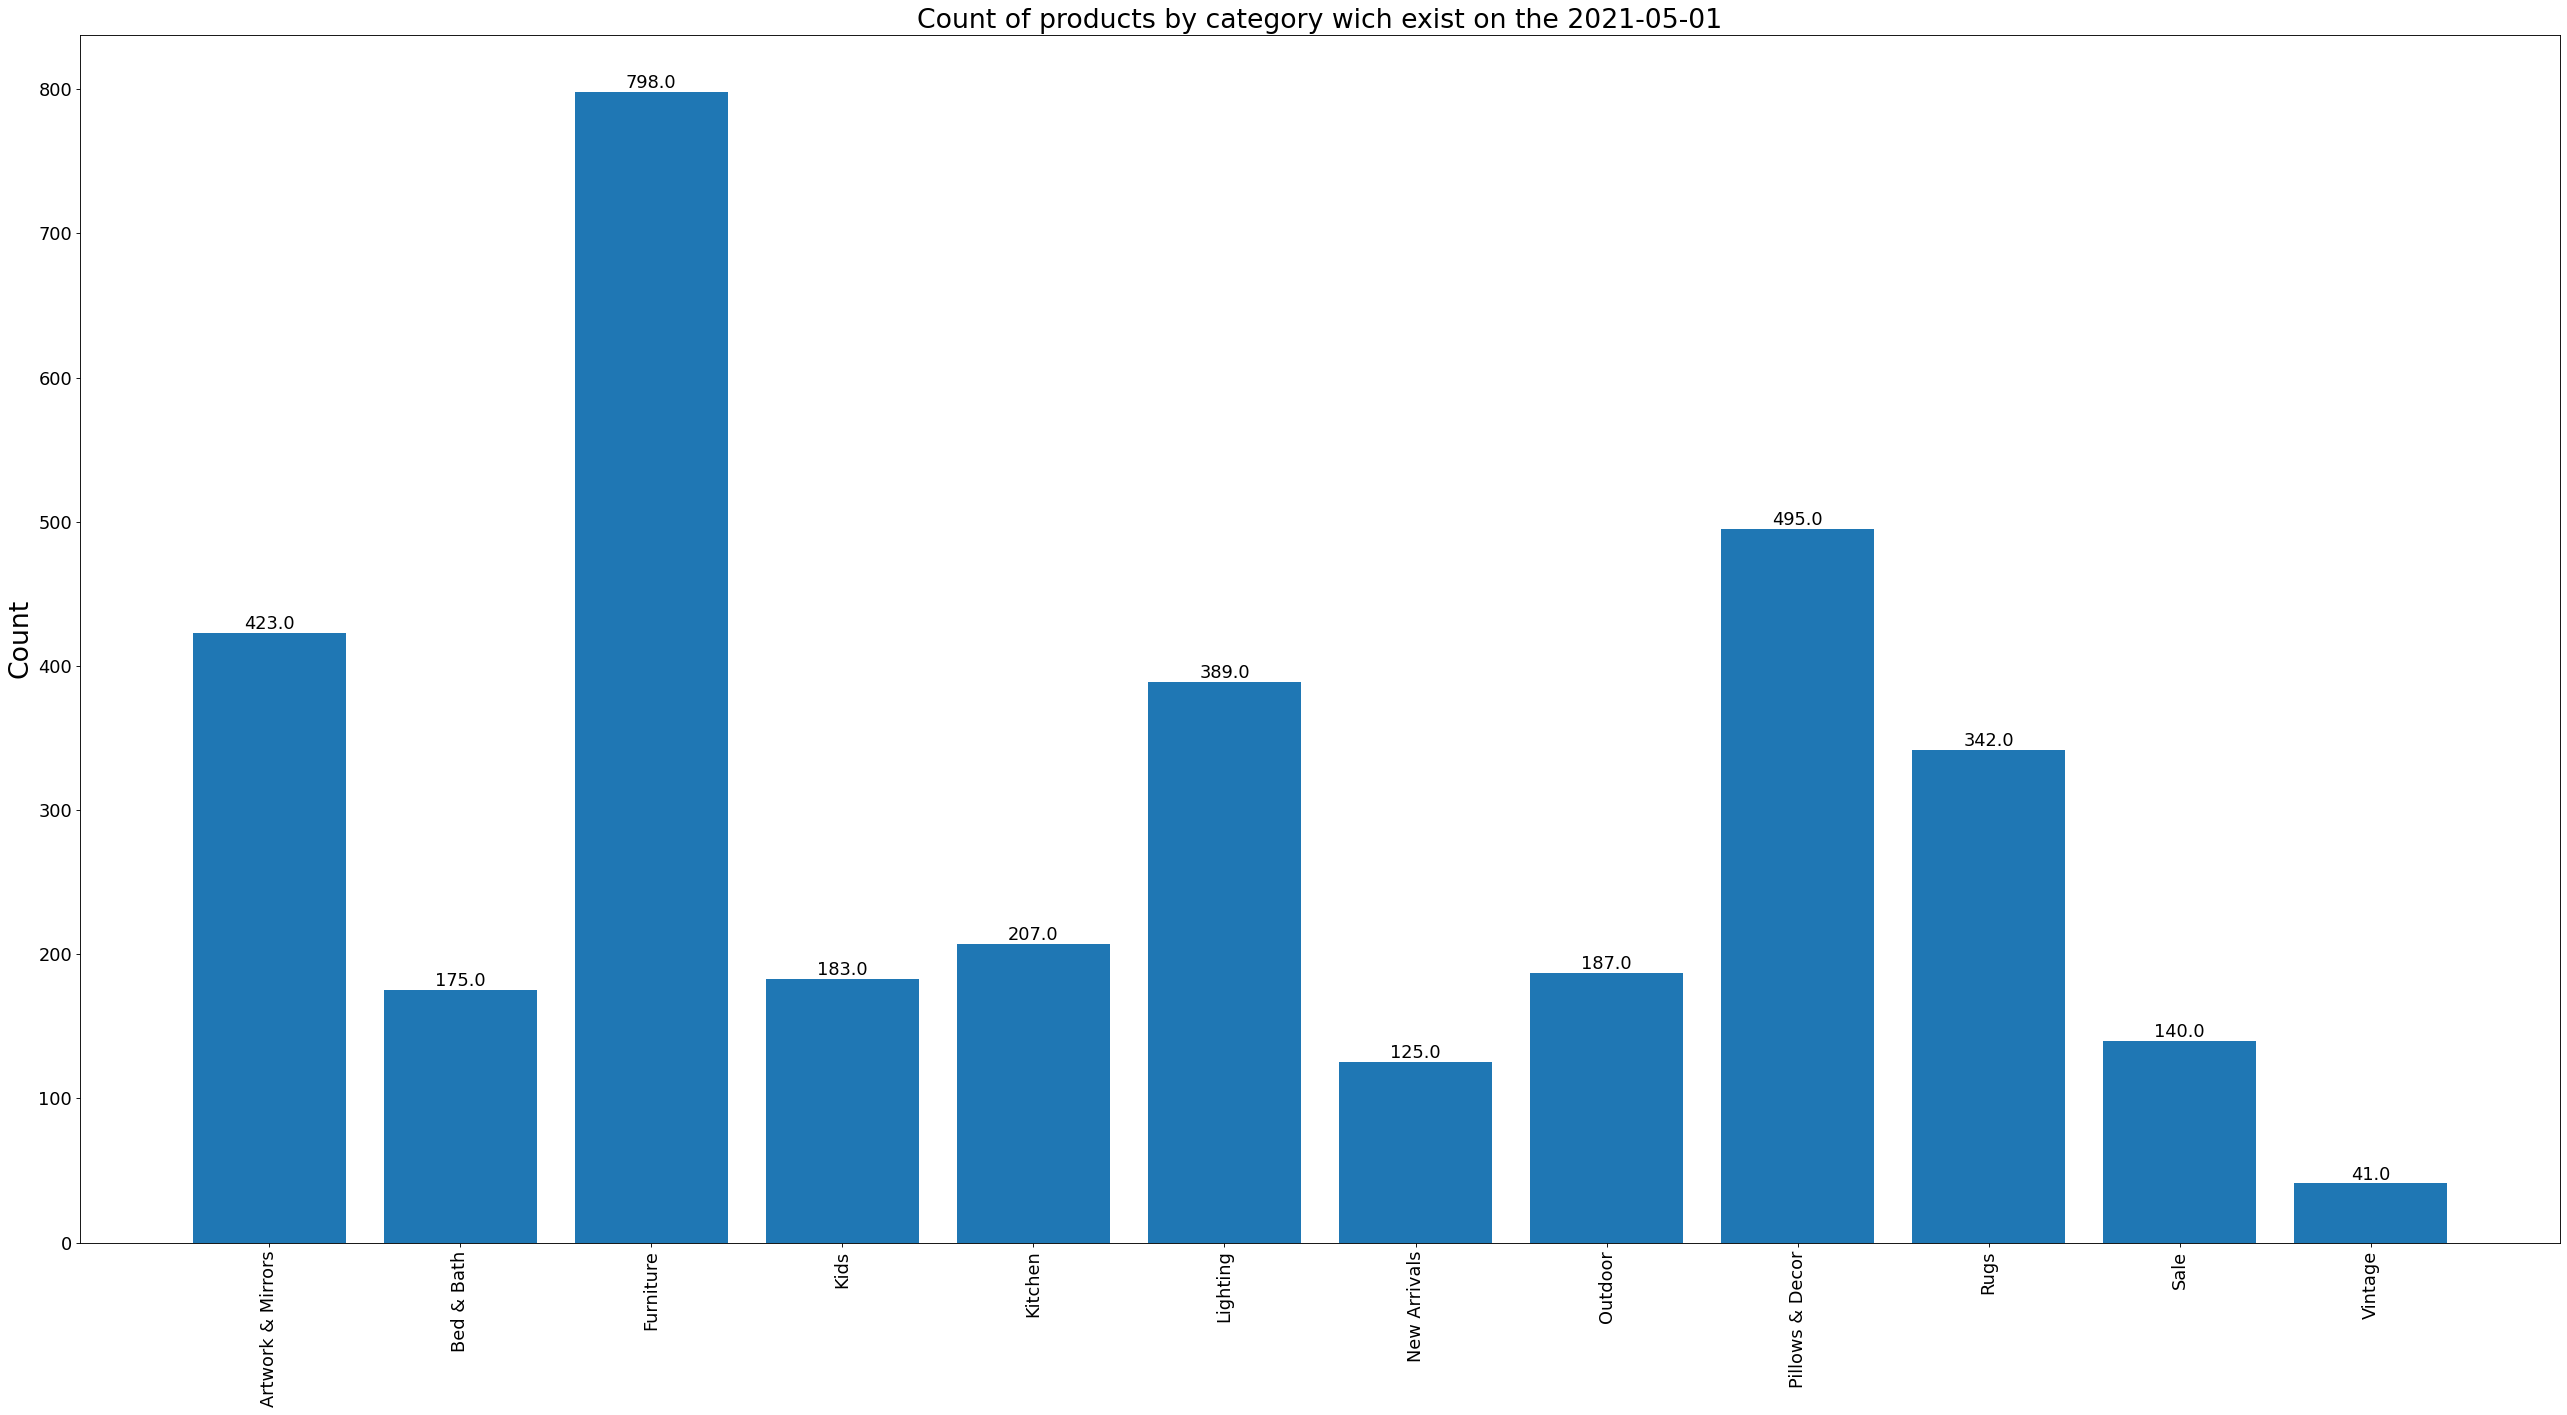

In [55]:
df = date_condition.groupby("category").size().reset_index(name="counts")
c = df["counts"]
plot_bar(df["category"], df["counts"])
plt.title(f"Count of products by category wich exist on the {date_picker}", fontsize=24)

Text(0.5, 1.0, 'Count of products by subcategory wich exist on the 2021-05-01')

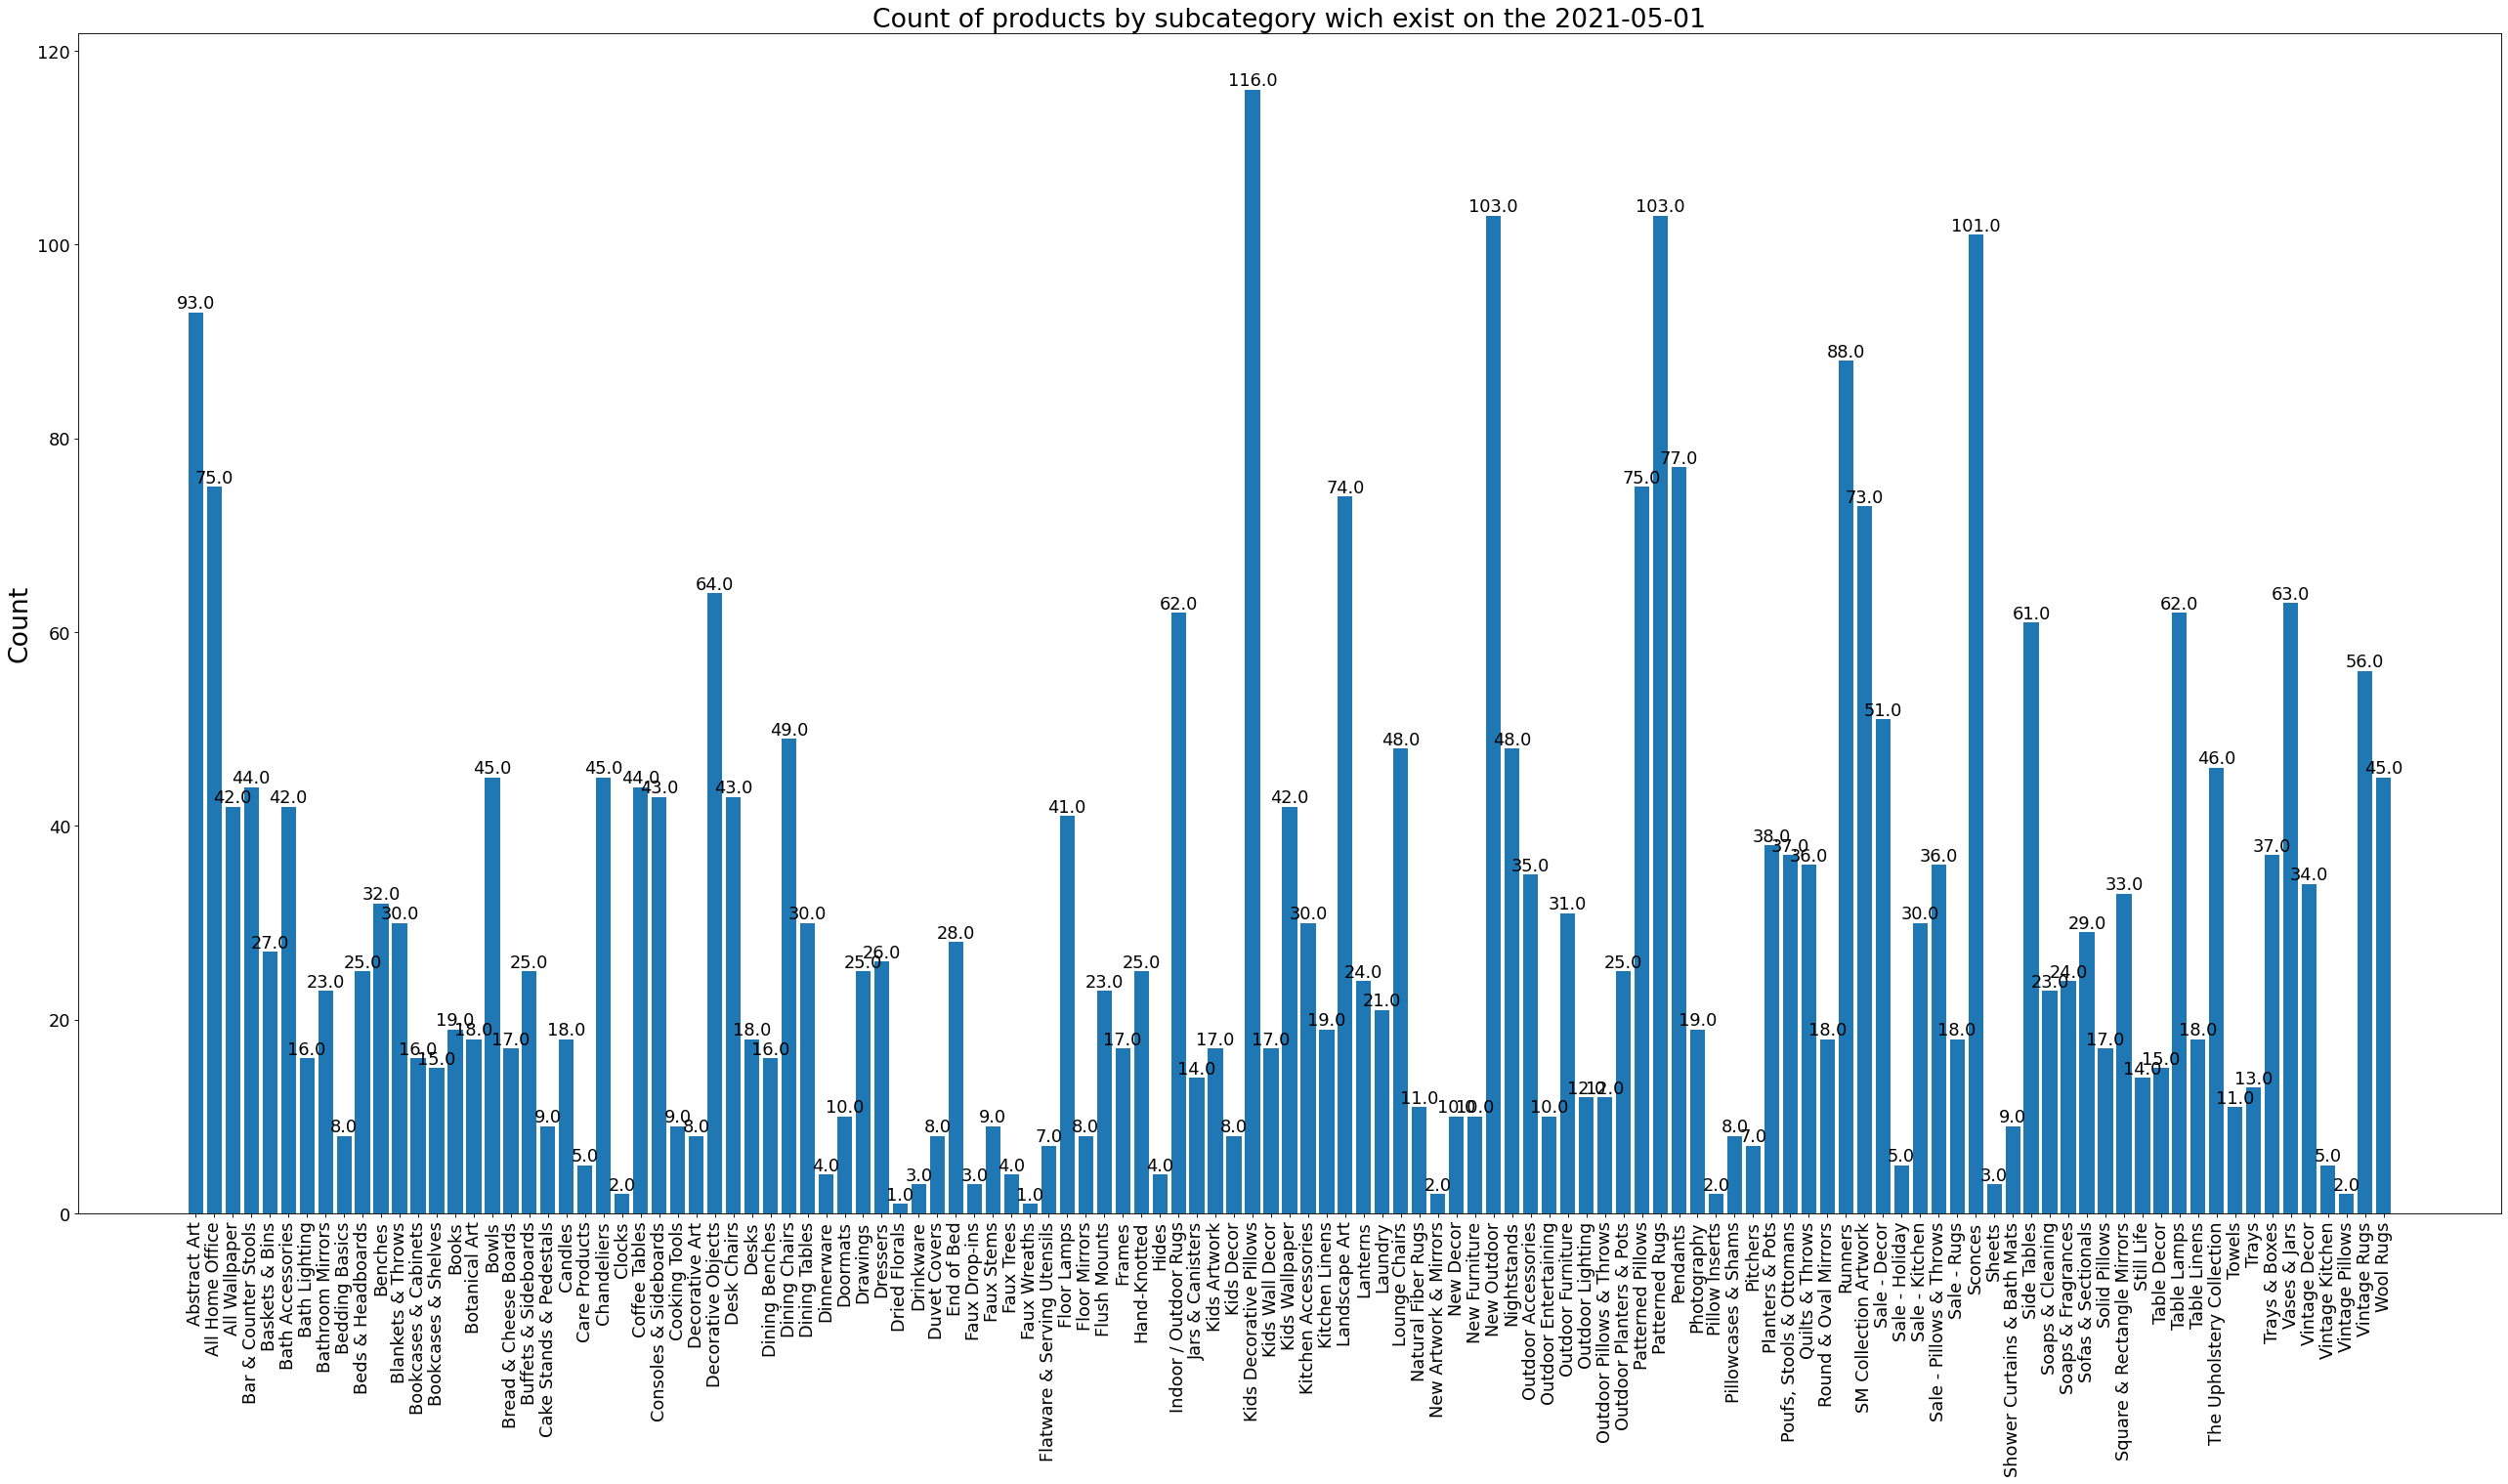

In [56]:
df = date_condition.groupby("subcategory").size().reset_index(name="counts")
c = df["counts"]
plot_bar(df["subcategory"], df["counts"])
plt.title(f"Count of products by subcategory wich exist on the {date_picker}", fontsize=24)

In [57]:
purchase_yes = dataset[(dataset["purchase_opportunity"] != "No") & (dataset["created_at"] < date_picker)]

Text(0.5, 1.0, 'Count of products by category wich possible to order on the 2021-05-01')

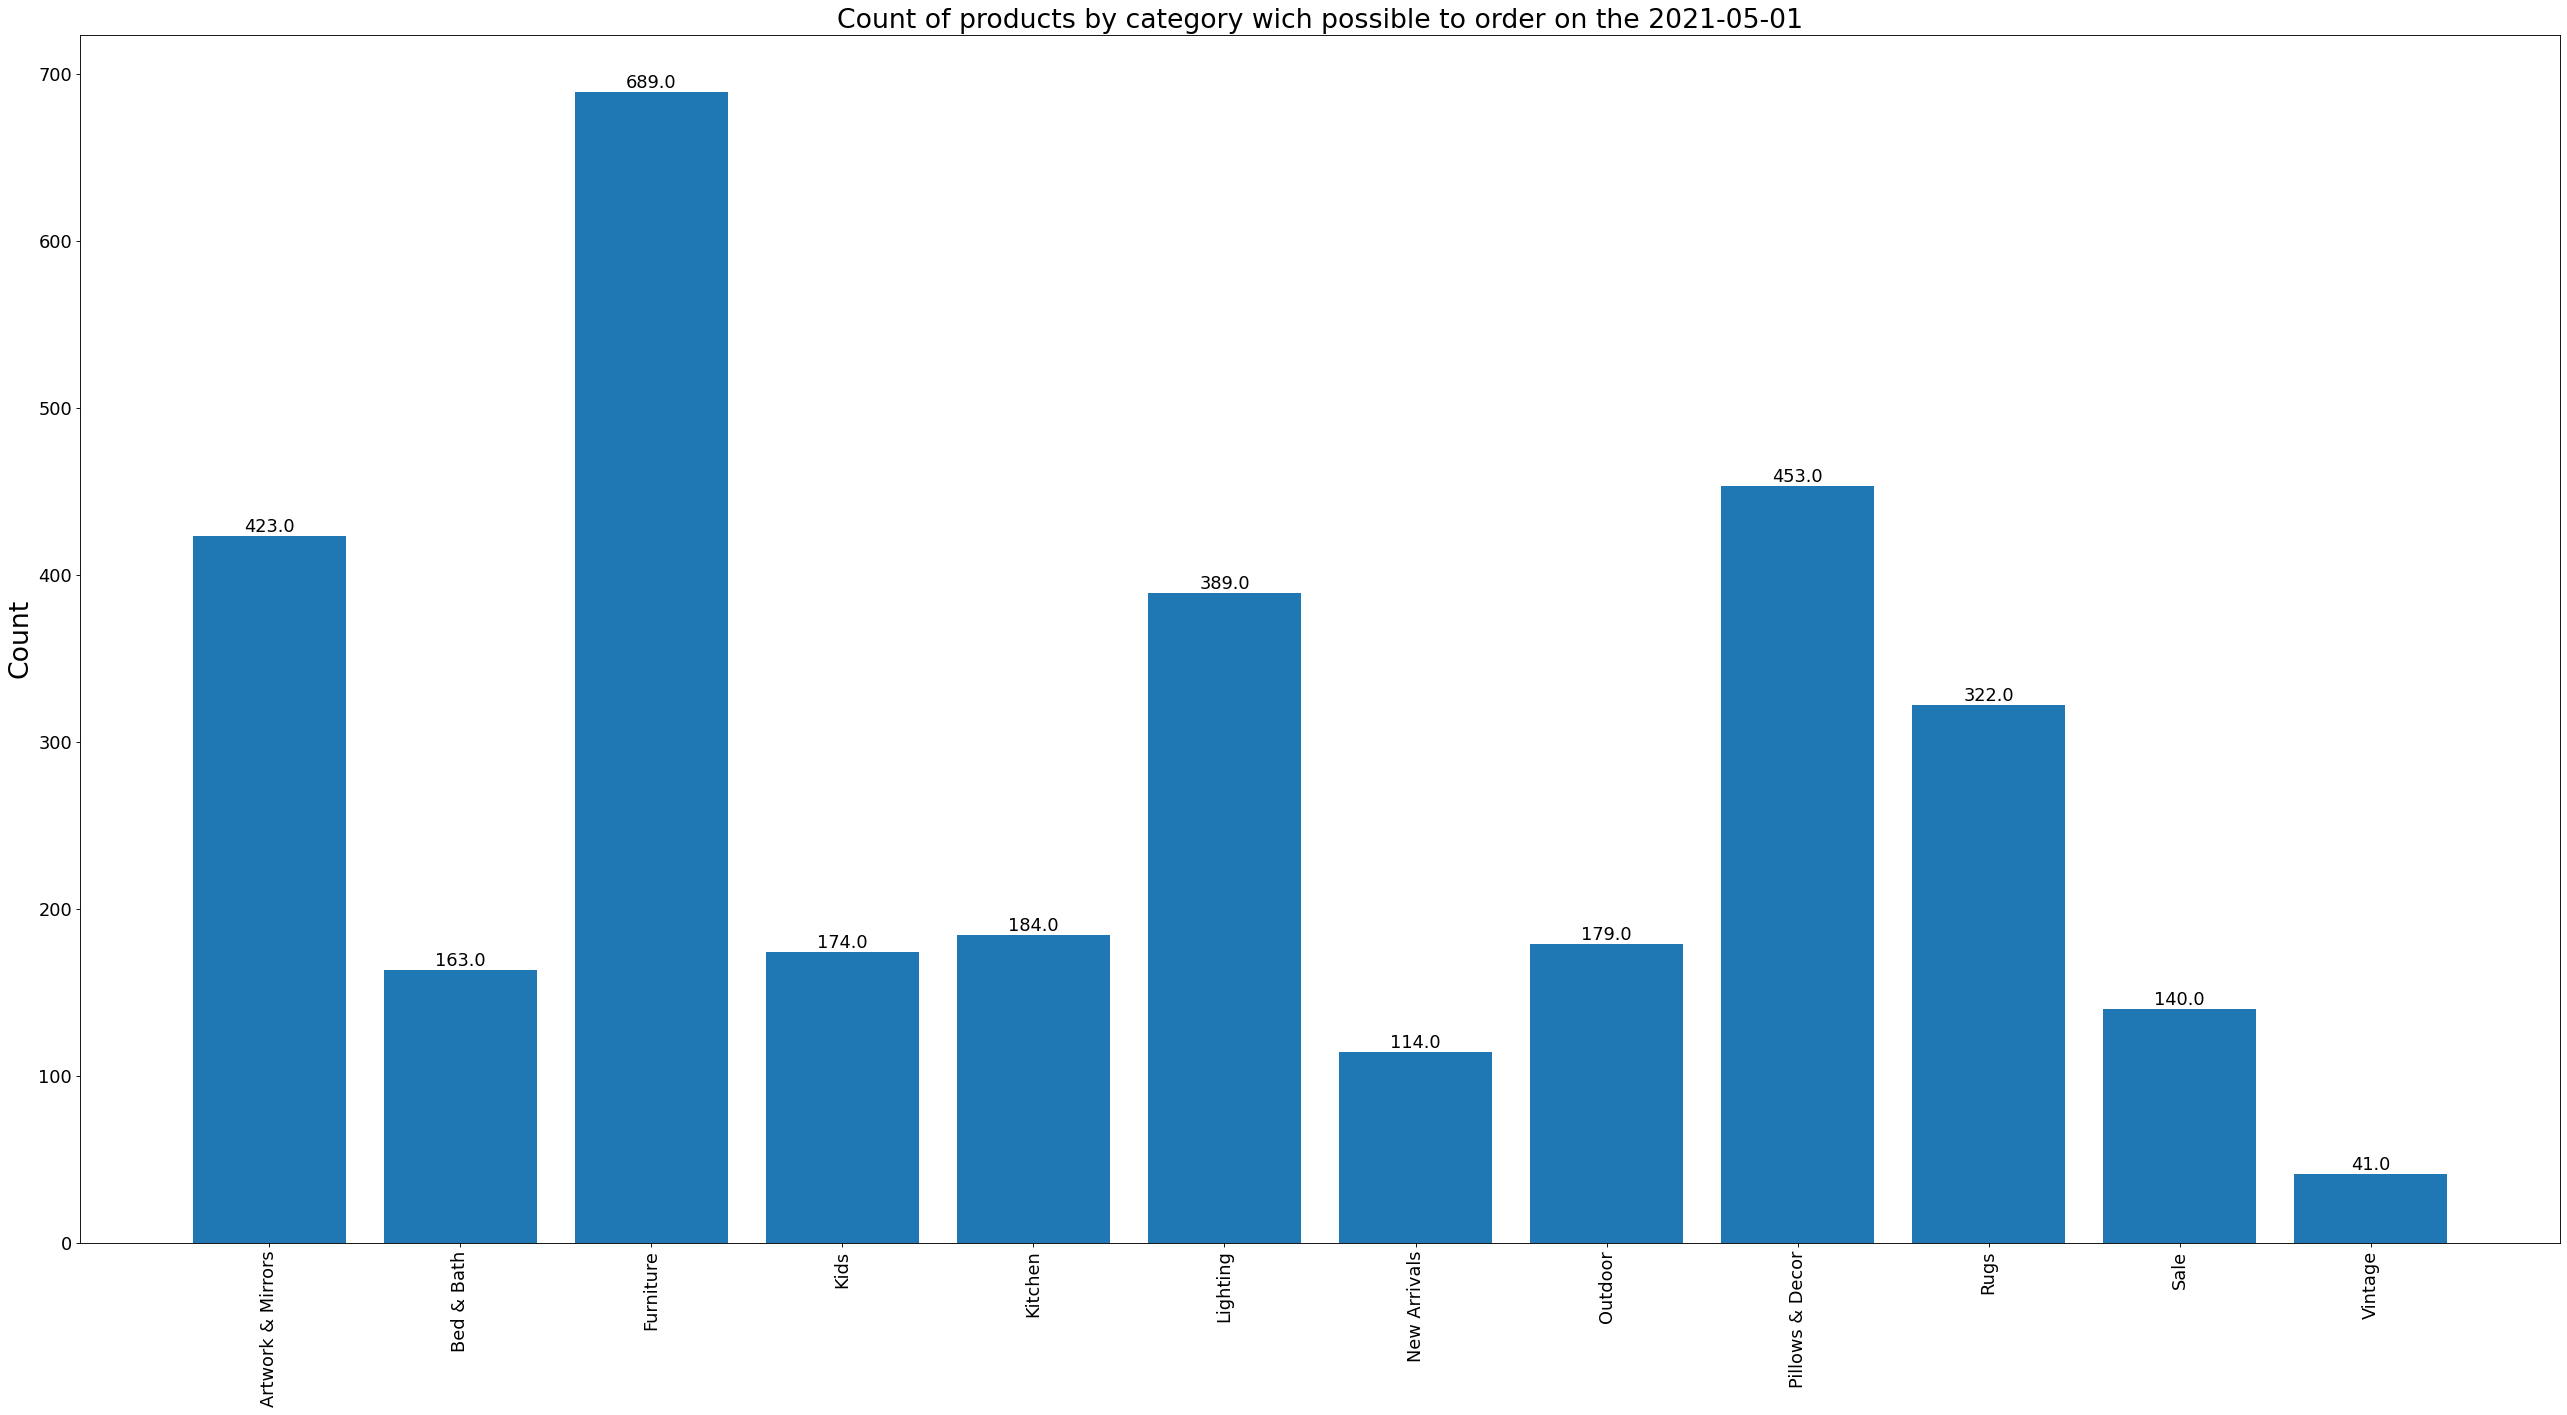

In [58]:
df = purchase_yes.groupby("category").size().reset_index(name="counts")
c = df["counts"]
plot_bar(df["category"], df["counts"])
plt.title(f"Count of products by category wich possible to order on the {date_picker}", fontsize=24)

Text(0.5, 1.0, 'Count of products by subcategory wich possible to order on the 2021-05-01')

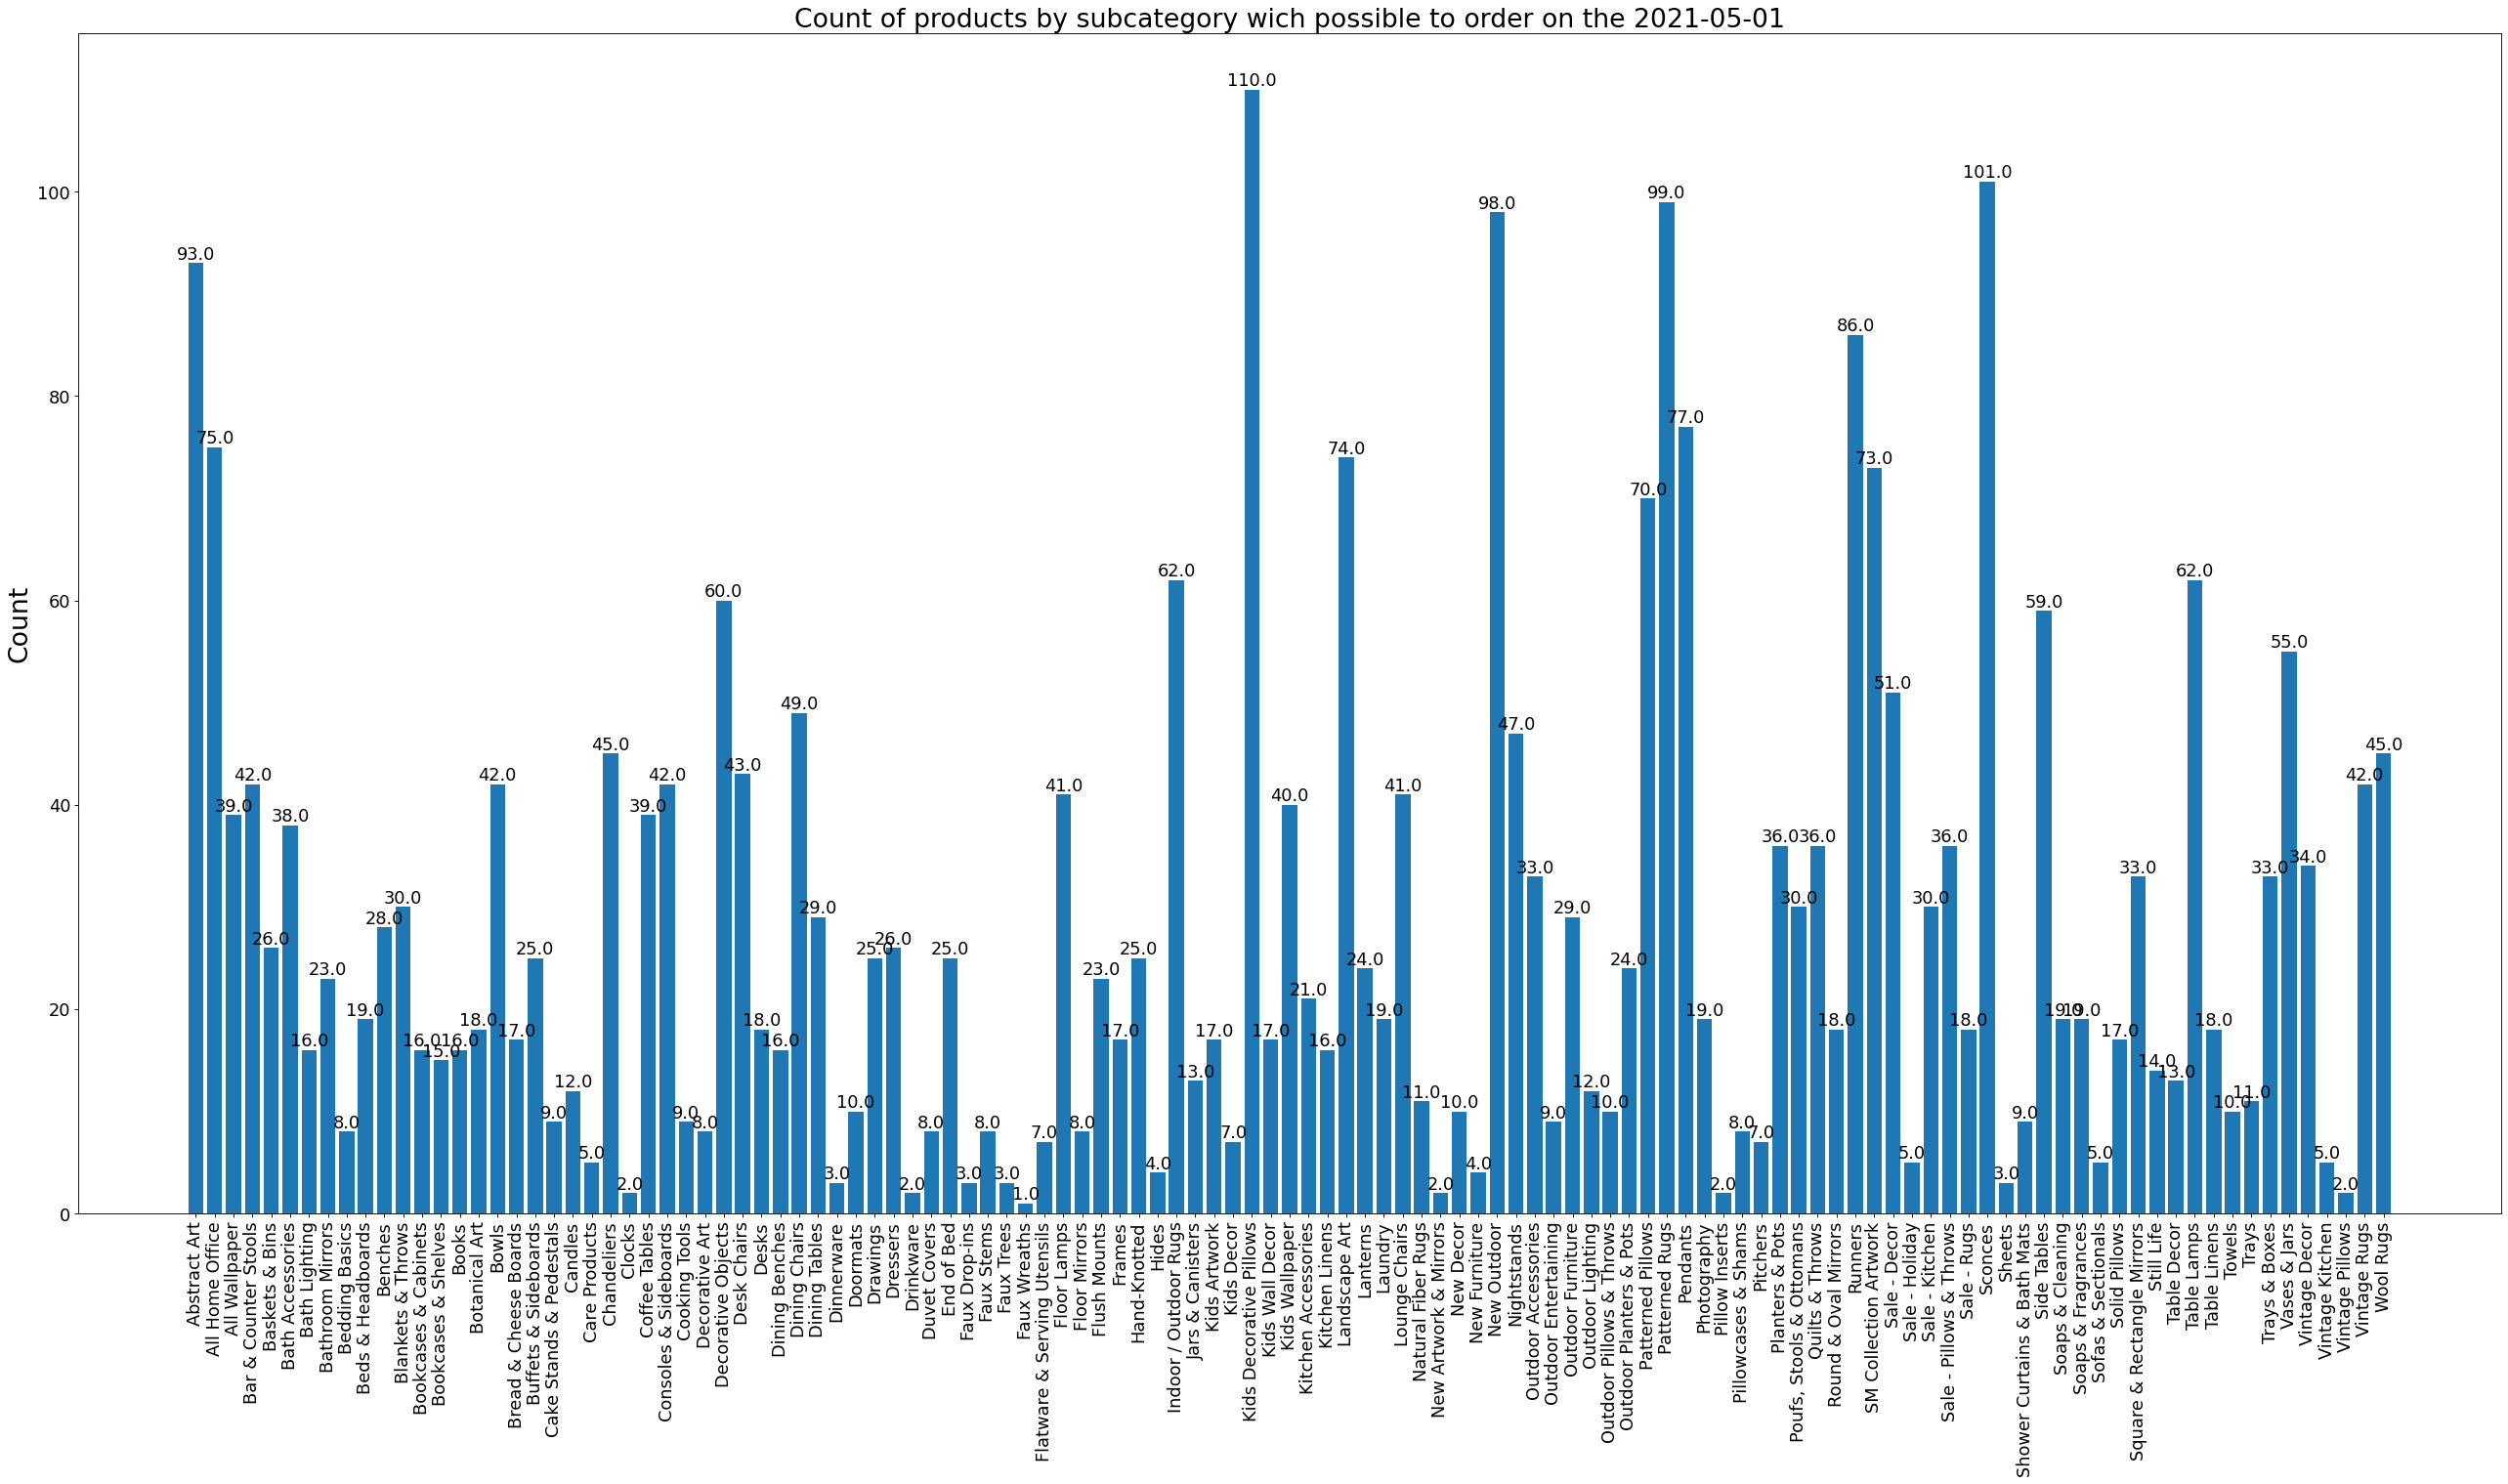

In [59]:
df = purchase_yes.groupby("subcategory").size().reset_index(name="counts")
c = df["counts"]
plot_bar(df["subcategory"], df["counts"])
plt.title(f"Count of products by subcategory wich possible to order on the {date_picker}", fontsize=24)

In [60]:
df_in_month = dataset[(dataset["created_at"] > "2021-10-31") & (dataset["created_at"] < "2021-12-01")]
purchase_not_now = df_in_month[df_in_month["purchase_opportunity"] == "No"]

Text(0.5, 1.0, "Count of products by subcategory wich was created in month and can't be bought now")

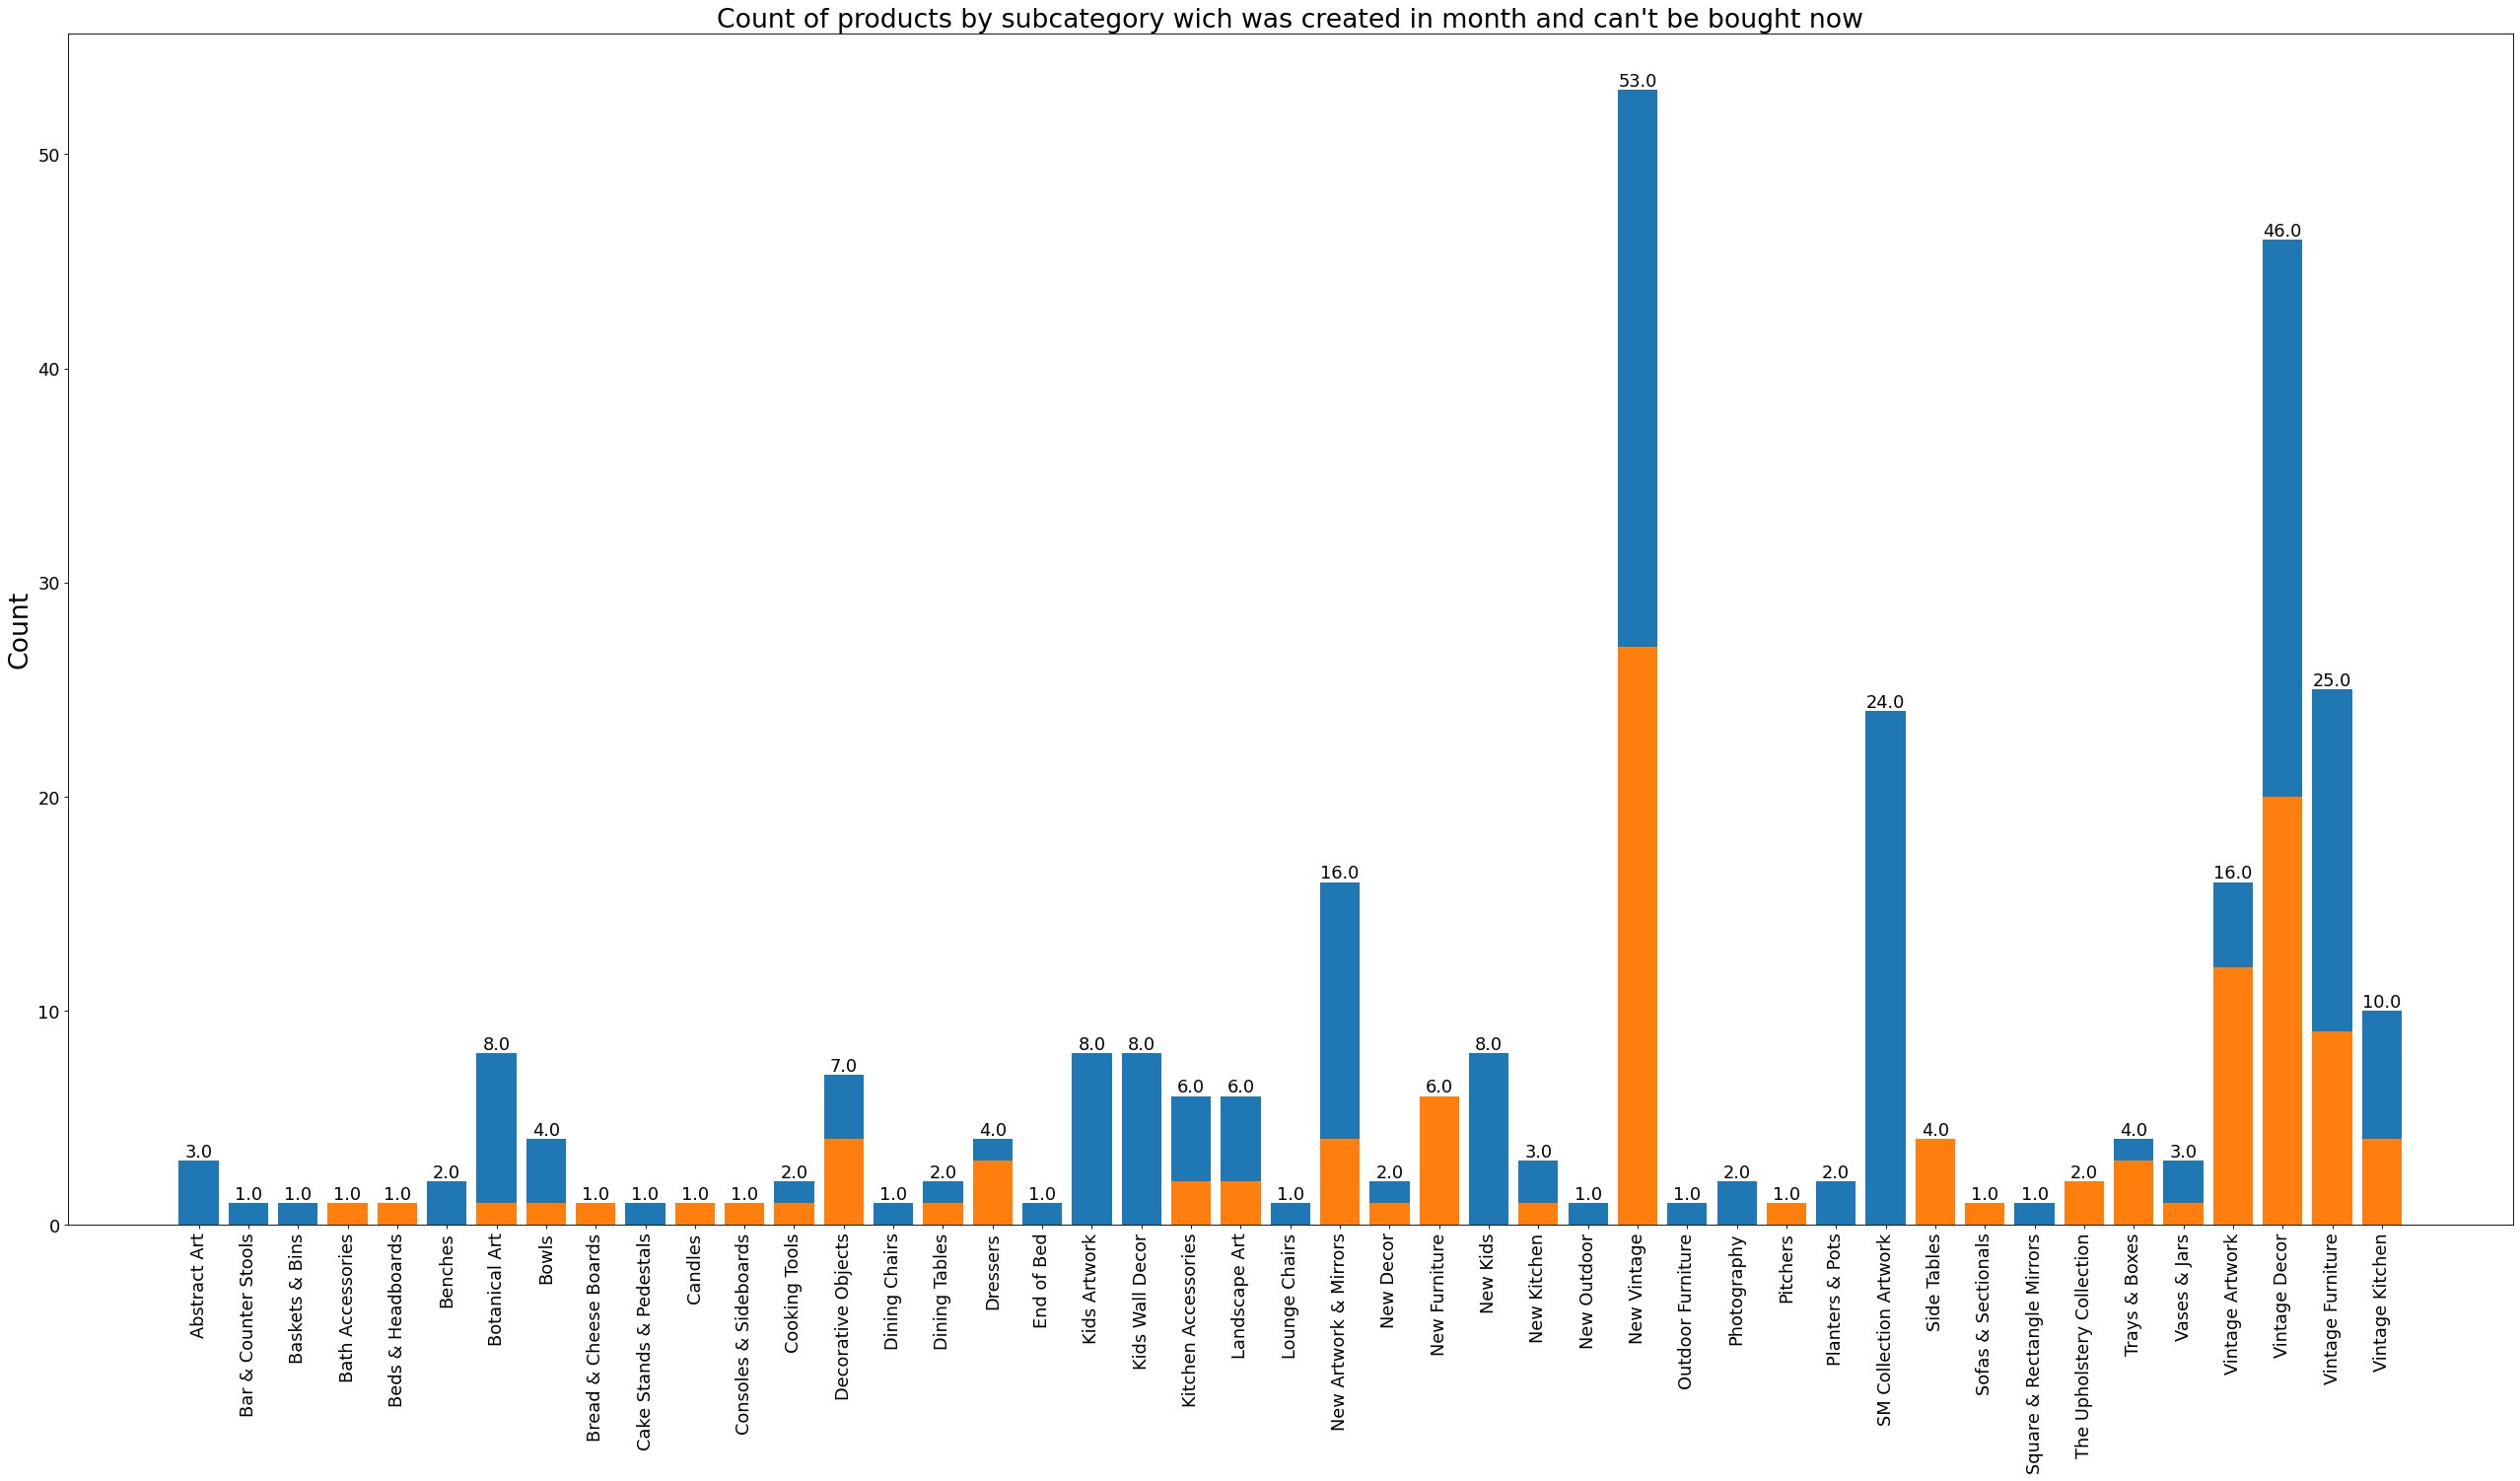

In [61]:
df = df_in_month.groupby("subcategory").size().reset_index(name="counts")
df1 = purchase_not_now.groupby("subcategory").size().reset_index(name="counts")
c = df["counts"]

plt.figure(figsize=(40,20), dpi= 80)
plt.bar(df["subcategory"], df["counts"])
plt.bar(df1["subcategory"], df1["counts"])
plt.xticks(rotation = 90, size = 16)
plt.yticks(size = 16)
for i, val in enumerate(c.values):
        plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':16})
plt.ylabel("Count", fontsize=24)
plt.title(f"Count of products by subcategory wich was created in month and can't be bought now", fontsize=24)